# <u>MNIST Digit Recognition Using FCN in PyTorch</u>
#### <u>Daniel Arama</u>
<br>

#### Imports

In [178]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### <u>Preparing and examining the datasets</u>

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,),)])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

In [3]:
seed = 42
np.random.seed(seed)

#Splitting the train set into train and validation
indices = np.random.permutation(len(trainset))
valid_size = 0.2

num_samples = len(trainset)
num_valid = int(valid_size * num_samples)
num_train = num_samples - num_valid

train_indices = indices[:num_train]
valid_indices = indices[num_train:]

train_subset = Subset(trainset, train_indices)
valid_subset = Subset(trainset, valid_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset))

validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))

In [4]:
print('Train set length: {0}'.format(len(train_subset)))
print('Validation set length: {0}'.format(len(valid_subset)))
print('Test set length: {0}'.format(len(testset)))

Train set length: 48000
Validation set length: 12000
Test set length: 10000


In [5]:
def plot_class_distribution(loader1, loader2, loader3, title, colors):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3)) 
    fig.suptitle("Class Distributions")
    for idx, loader in enumerate([loader1, loader2, loader3]):
        class_count = [0] * 10
        for _, labels in loader:
            for label in labels.numpy():
                class_count[label] += 1

        classes = list(range(10))
        axes[idx].bar(classes, class_count, color=colors[idx])
        axes[idx].set_title(title[idx])
        axes[idx].set_xticks(classes)

    plt.tight_layout()  
    plt.show()

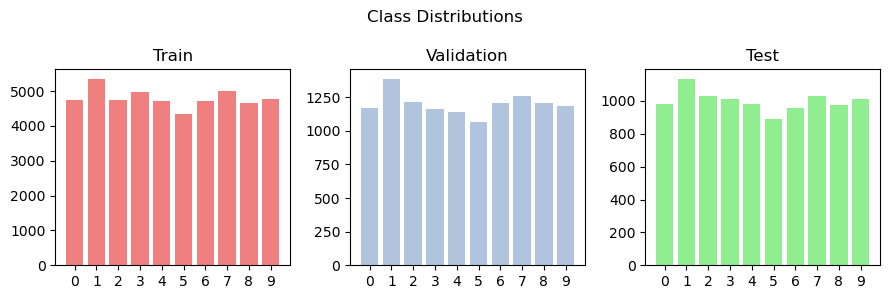

In [6]:
plot_class_distribution(trainloader, validloader, testloader,\
                        ["Train","Validation","Test"], ["lightcoral","lightsteelblue","lightgreen"])

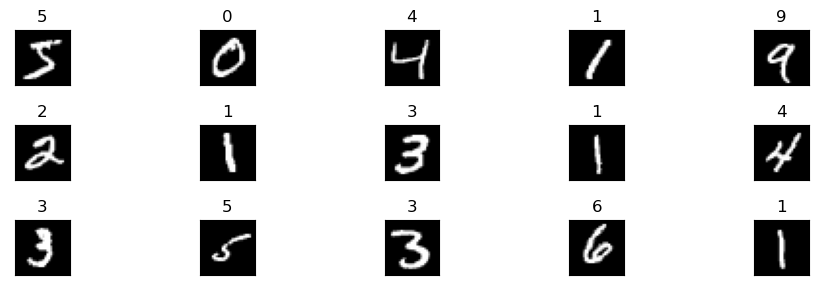

In [7]:
fig = plt.figure(figsize=(10,3))
for idx in np.arange(15):
    ax = fig.add_subplot(3, int(15/3), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(trainset[idx][0]), cmap='gray')
    ax.set_title(trainset[idx][1])
fig.tight_layout()

### <u>Neural Network Implementation and Hyperparameter Tuning</u>

In [8]:
#Loss visualization plot 
def loss_vis(loss_1, loss_2, label_1, label_2, title):
    epochs = range(1, len(loss_1) + 1)
    plt.plot(epochs, [loss.item() for loss in loss_1], label=label_1, color='firebrick')
    plt.plot(epochs, [loss.item() for loss in loss_2], label=label_2, color='mediumblue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
#Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [10]:
#2 layer model
class BaseModel2(nn.Module):
    def __init__(self, dropout_p):
        super(BaseModel2, self).__init__()
        self.linear1 = nn.Linear(28*28, 196) 
        self.dropout1 = nn.Dropout(dropout_p) 
        self.linear2 = nn.Linear(196, 49)
        self.dropout2 = nn.Dropout(dropout_p)  
        self.final = nn.Linear(49, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x) 
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)  
        x = self.final(x)
        return x

In [11]:
#3 layer model
class BaseModel3(nn.Module):
    def __init__(self, dropout_p):
        super(BaseModel3, self).__init__()
        self.linear1 = nn.Linear(28*28, 196) 
        self.dropout1 = nn.Dropout(dropout_p) 
        self.linear2 = nn.Linear(196, 98)
        self.dropout2 = nn.Dropout(dropout_p)  
        self.linear3 = nn.Linear(98, 49)
        self.dropout3 = nn.Dropout(dropout_p)  
        self.final = nn.Linear(49, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x) 
        x = self.relu(self.linear2(x))
        x = self.dropout2(x) 
        x = self.relu(self.linear3(x))
        x = self.dropout3(x) 
        x = self.final(x)
        return x

In [12]:
def ModelTraining(layers, batch_size, lr, l2, dropout_p, patience=5, epochs_per_print = 10, num_epochs = 50):
    
    if layers == 2:
        model = BaseModel2(dropout_p)
    else:
        model = BaseModel3(dropout_p)
             
    #Lists of loss per epoch
    train_losses = []
    valid_losses = []
    
    #Loaders
    validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    
    #Size of train subset
    train_set_size = len(train_subset)

    #Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2)
    
    #Early stopping improvment constant 
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    best_valid_acc = 0
    
    #Training loop
    for epoch in range(num_epochs):

        model.train()
        total_loss_train = 0
        
        for batch_idx, (data, target) in enumerate(trainloader):

            output_train = model(data)
            loss_train = loss_fn(output_train, target)
            total_loss_train += loss_train
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
        #Train loss average in current epoch
        total_loss_train /= (train_set_size/batch_size)
        train_losses.append(total_loss_train)
        
        #Evaluation
        model.eval()
        with torch.inference_mode():
            
            #Accuracy and loss in valid
            for batch_idx, (data_valid, target_valid) in enumerate(validloader):
                output_valid = model(data_valid)
                pred_valid = torch.softmax(output_valid, dim=1).argmax(dim=1)
                loss_valid = loss_fn(output_valid, target_valid)
                acc_valid = accuracy_fn(target_valid, pred_valid)
                
            valid_losses.append(loss_valid)
            
            #Early stopping
            if loss_valid < best_valid_loss:
                best_valid_loss = loss_valid
                epochs_no_improve = 0
                
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch}, with {best_valid_loss:.5f} validation loss')
                    break

        #Calculating train accuracy and printing whats happaning
        if epoch % epochs_per_print == 0 or num_epochs == epoch-1:
            
            #acc in train
            total_acc_train = 0
            for batch_idx, (data, target) in enumerate(trainloader):
                output_train = model(data)
                pred_train = torch.softmax(output_train, dim=1).argmax(dim=1)
                total_acc_train += accuracy_fn(target, pred_train)
                
            total_acc_train /= (train_set_size/batch_size)
            
            print(f"Epoch: {epoch} | Train Loss: {total_loss_train:.5f}, Train Acc: {total_acc_train:.2f}% |\
            Validation Loss: {loss_valid:.5f}, Validation Acc: {acc_valid:.2f}%")
            
    return train_losses, valid_losses

### Mini Batch Gradietn Descent

#### 2 Layers, Mini Batch Size 30

Epoch: 0 | Train Loss: 2.15938, Train Acc: 54.04% |            Validation Loss: 1.94127, Validation Acc: 53.51%
Epoch: 10 | Train Loss: 0.35325, Train Acc: 90.25% |            Validation Loss: 0.35138, Validation Acc: 89.90%
Epoch: 20 | Train Loss: 0.29022, Train Acc: 91.79% |            Validation Loss: 0.29656, Validation Acc: 91.33%
Epoch: 30 | Train Loss: 0.25425, Train Acc: 92.71% |            Validation Loss: 0.26482, Validation Acc: 92.29%
Epoch: 40 | Train Loss: 0.22427, Train Acc: 93.66% |            Validation Loss: 0.23713, Validation Acc: 92.98%


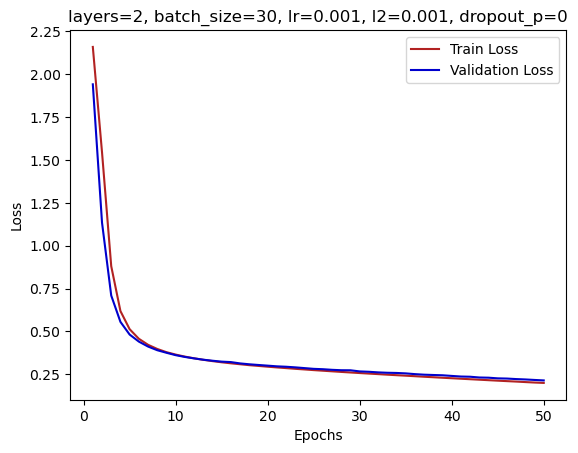

In [20]:
layers = 2
batch_size = 30
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.15572, Train Acc: 58.32% |            Validation Loss: 1.90957, Validation Acc: 57.81%
Epoch: 10 | Train Loss: 0.47416, Train Acc: 89.66% |            Validation Loss: 0.37079, Validation Acc: 89.19%
Epoch: 20 | Train Loss: 0.36320, Train Acc: 91.92% |            Validation Loss: 0.28803, Validation Acc: 91.36%
Epoch: 30 | Train Loss: 0.30530, Train Acc: 93.28% |            Validation Loss: 0.24111, Validation Acc: 92.66%
Epoch: 40 | Train Loss: 0.25941, Train Acc: 94.36% |            Validation Loss: 0.20679, Validation Acc: 93.73%


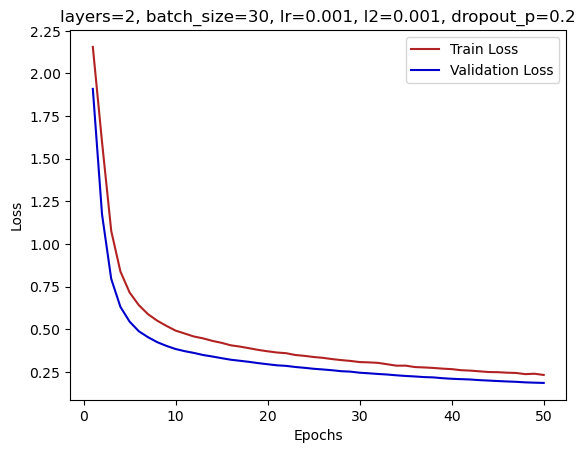

In [21]:
layers = 2
batch_size = 30
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.12659, Train Acc: 45.65% |            Validation Loss: 1.88644, Validation Acc: 45.59%
Epoch: 10 | Train Loss: 0.37544, Train Acc: 89.62% |            Validation Loss: 0.37381, Validation Acc: 89.35%
Epoch: 20 | Train Loss: 0.31946, Train Acc: 91.10% |            Validation Loss: 0.32398, Validation Acc: 90.81%
Epoch: 30 | Train Loss: 0.29017, Train Acc: 92.08% |            Validation Loss: 0.29539, Validation Acc: 91.68%
Epoch: 40 | Train Loss: 0.26752, Train Acc: 92.74% |            Validation Loss: 0.27491, Validation Acc: 92.15%


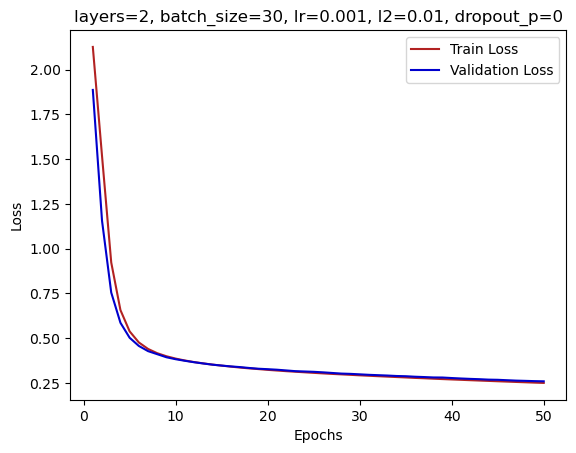

In [22]:
layers = 2
batch_size = 30
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.20308, Train Acc: 50.58% |            Validation Loss: 2.01182, Validation Acc: 50.05%
Epoch: 10 | Train Loss: 0.49913, Train Acc: 89.36% |            Validation Loss: 0.39144, Validation Acc: 89.16%
Epoch: 20 | Train Loss: 0.39702, Train Acc: 91.13% |            Validation Loss: 0.31794, Validation Acc: 90.76%
Epoch: 30 | Train Loss: 0.35136, Train Acc: 92.15% |            Validation Loss: 0.28458, Validation Acc: 91.57%
Epoch: 40 | Train Loss: 0.32384, Train Acc: 93.10% |            Validation Loss: 0.25862, Validation Acc: 92.67%


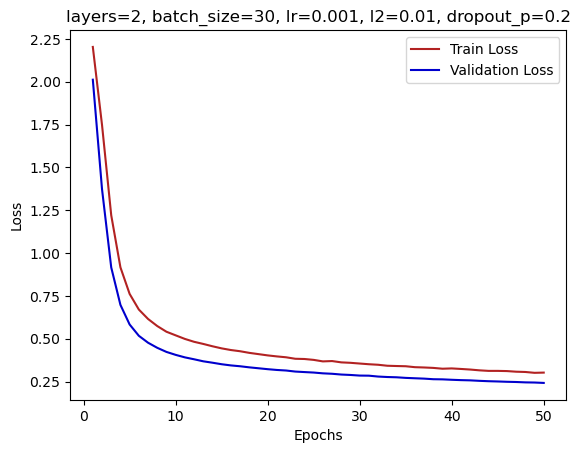

In [23]:
layers = 2
batch_size = 30
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.79481, Train Acc: 89.02% |            Validation Loss: 0.38552, Validation Acc: 88.81%
Epoch: 10 | Train Loss: 0.10883, Train Acc: 97.05% |            Validation Loss: 0.12838, Validation Acc: 95.99%
Epoch: 20 | Train Loss: 0.05878, Train Acc: 98.65% |            Validation Loss: 0.08985, Validation Acc: 97.18%
Epoch: 30 | Train Loss: 0.03978, Train Acc: 99.24% |            Validation Loss: 0.07923, Validation Acc: 97.56%
Epoch: 40 | Train Loss: 0.03043, Train Acc: 99.55% |            Validation Loss: 0.07241, Validation Acc: 97.72%
Early stopping at epoch 45, with 0.07241 validation loss


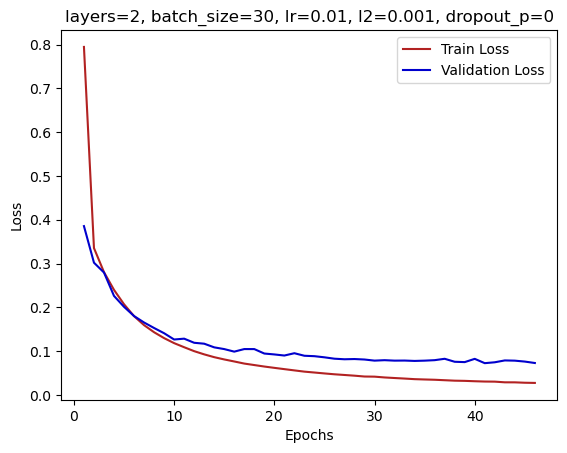

In [24]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.88228, Train Acc: 89.21% |            Validation Loss: 0.38087, Validation Acc: 88.91%
Epoch: 10 | Train Loss: 0.15343, Train Acc: 97.05% |            Validation Loss: 0.12267, Validation Acc: 96.32%
Epoch: 20 | Train Loss: 0.10242, Train Acc: 98.17% |            Validation Loss: 0.09306, Validation Acc: 97.12%
Epoch: 30 | Train Loss: 0.08340, Train Acc: 98.82% |            Validation Loss: 0.08059, Validation Acc: 97.40%
Epoch: 40 | Train Loss: 0.06988, Train Acc: 99.04% |            Validation Loss: 0.07605, Validation Acc: 97.52%
Early stopping at epoch 48, with 0.07360 validation loss


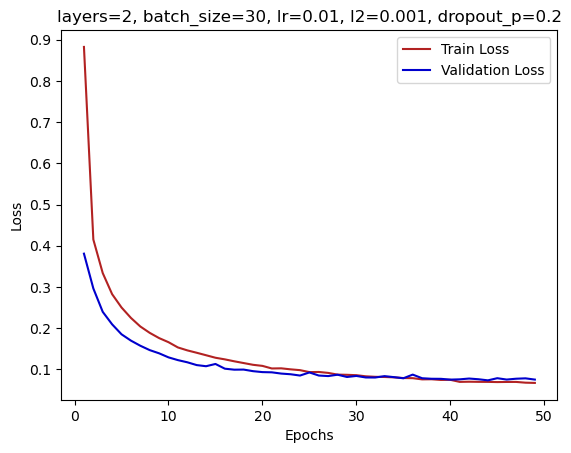

In [25]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.77692, Train Acc: 89.11% |            Validation Loss: 0.39483, Validation Acc: 88.83%
Epoch: 10 | Train Loss: 0.20054, Train Acc: 94.63% |            Validation Loss: 0.21006, Validation Acc: 94.00%
Epoch: 20 | Train Loss: 0.16719, Train Acc: 95.56% |            Validation Loss: 0.18547, Validation Acc: 94.91%
Epoch: 30 | Train Loss: 0.15650, Train Acc: 96.32% |            Validation Loss: 0.16645, Validation Acc: 95.52%
Early stopping at epoch 38, with 0.16282 validation loss


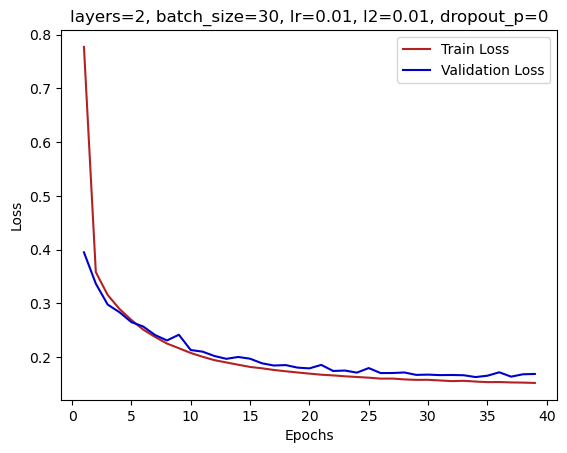

In [26]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.95315, Train Acc: 88.42% |            Validation Loss: 0.42567, Validation Acc: 87.90%
Epoch: 10 | Train Loss: 0.25143, Train Acc: 94.81% |            Validation Loss: 0.20104, Validation Acc: 94.29%
Epoch: 20 | Train Loss: 0.22189, Train Acc: 95.75% |            Validation Loss: 0.17653, Validation Acc: 95.16%
Early stopping at epoch 26, with 0.17193 validation loss


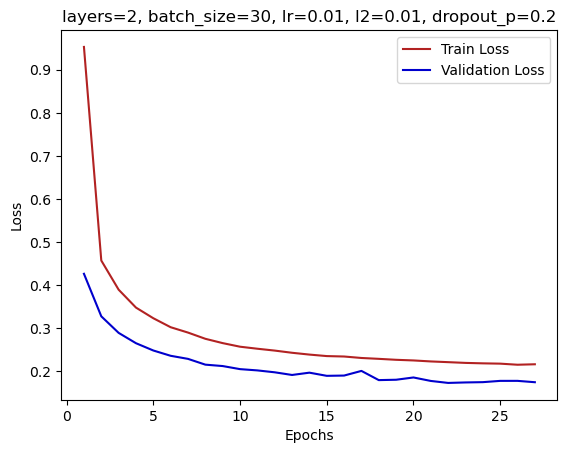

In [27]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

#### 2 Layers, Mini Batch Size 120

Epoch: 0 | Train Loss: 2.25694, Train Acc: 21.08% |            Validation Loss: 2.21131, Validation Acc: 21.49%
Epoch: 10 | Train Loss: 0.81037, Train Acc: 80.98% |            Validation Loss: 0.77354, Validation Acc: 80.88%
Epoch: 20 | Train Loss: 0.46749, Train Acc: 87.41% |            Validation Loss: 0.46146, Validation Acc: 87.10%
Epoch: 30 | Train Loss: 0.38999, Train Acc: 89.02% |            Validation Loss: 0.38945, Validation Acc: 88.83%
Epoch: 40 | Train Loss: 0.35473, Train Acc: 89.88% |            Validation Loss: 0.35690, Validation Acc: 89.62%


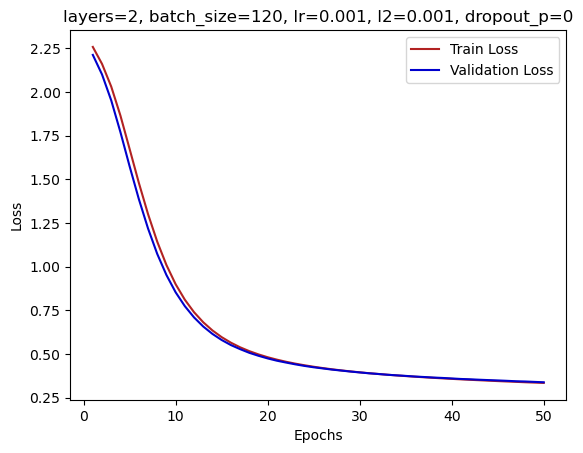

In [28]:
layers = 2
batch_size = 120
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.28406, Train Acc: 26.00% |            Validation Loss: 2.24824, Validation Acc: 26.52%
Epoch: 10 | Train Loss: 1.07008, Train Acc: 79.39% |            Validation Loss: 0.89890, Validation Acc: 79.43%
Epoch: 20 | Train Loss: 0.66256, Train Acc: 86.37% |            Validation Loss: 0.52796, Validation Acc: 86.37%
Epoch: 30 | Train Loss: 0.54292, Train Acc: 88.45% |            Validation Loss: 0.42743, Validation Acc: 88.15%
Epoch: 40 | Train Loss: 0.48288, Train Acc: 89.46% |            Validation Loss: 0.38057, Validation Acc: 89.03%


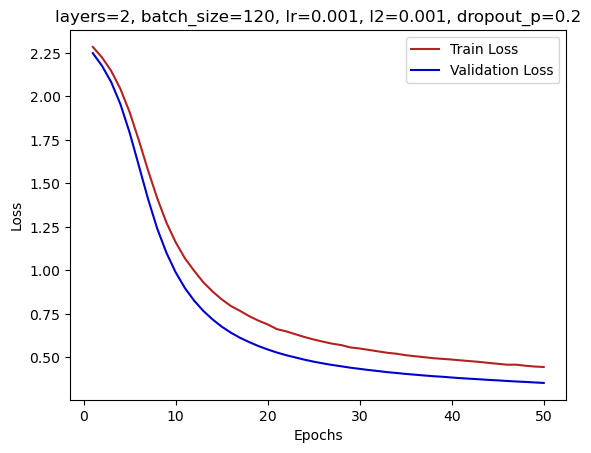

In [29]:
layers = 2
batch_size = 120
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.25111, Train Acc: 36.50% |            Validation Loss: 2.20089, Validation Acc: 36.83%
Epoch: 10 | Train Loss: 0.79890, Train Acc: 80.70% |            Validation Loss: 0.77156, Validation Acc: 80.65%
Epoch: 20 | Train Loss: 0.49965, Train Acc: 86.50% |            Validation Loss: 0.49608, Validation Acc: 86.25%
Epoch: 30 | Train Loss: 0.41468, Train Acc: 88.67% |            Validation Loss: 0.41556, Validation Acc: 88.60%
Epoch: 40 | Train Loss: 0.37597, Train Acc: 89.57% |            Validation Loss: 0.37878, Validation Acc: 89.46%


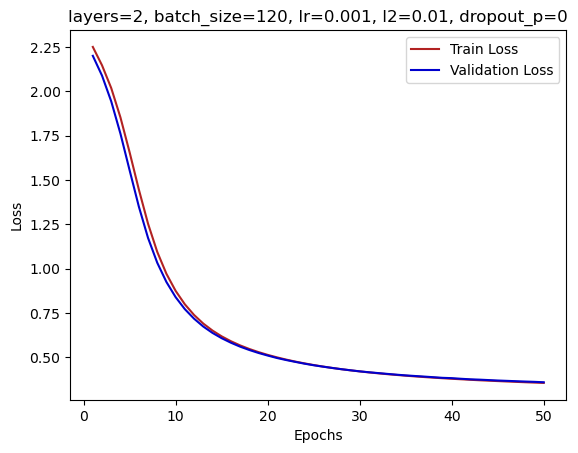

In [30]:
layers = 2
batch_size = 120
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.27774, Train Acc: 30.14% |            Validation Loss: 2.23681, Validation Acc: 29.62%
Epoch: 10 | Train Loss: 1.02207, Train Acc: 79.77% |            Validation Loss: 0.86438, Validation Acc: 80.02%
Epoch: 20 | Train Loss: 0.66835, Train Acc: 86.11% |            Validation Loss: 0.54194, Validation Acc: 86.25%
Epoch: 30 | Train Loss: 0.55518, Train Acc: 88.22% |            Validation Loss: 0.44655, Validation Acc: 88.24%
Epoch: 40 | Train Loss: 0.49502, Train Acc: 89.26% |            Validation Loss: 0.39907, Validation Acc: 89.08%


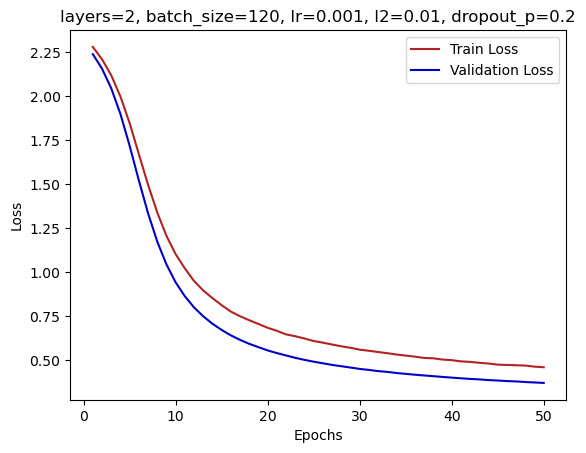

In [31]:
layers = 2
batch_size = 120
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.65820, Train Acc: 76.82% |            Validation Loss: 0.89780, Validation Acc: 76.54%
Epoch: 10 | Train Loss: 0.26998, Train Acc: 92.42% |            Validation Loss: 0.27231, Validation Acc: 91.88%
Epoch: 20 | Train Loss: 0.19070, Train Acc: 94.77% |            Validation Loss: 0.20175, Validation Acc: 94.11%
Epoch: 30 | Train Loss: 0.13991, Train Acc: 96.20% |            Validation Loss: 0.15592, Validation Acc: 95.19%
Epoch: 40 | Train Loss: 0.10797, Train Acc: 97.12% |            Validation Loss: 0.13153, Validation Acc: 95.97%


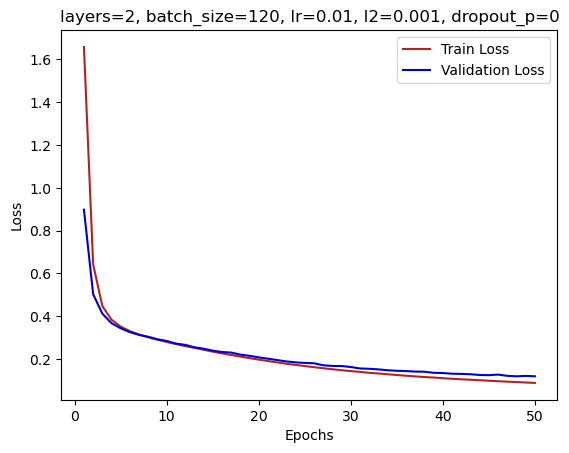

In [32]:
layers = 2
batch_size = 120
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.69045, Train Acc: 78.28% |            Validation Loss: 0.92072, Validation Acc: 78.44%
Epoch: 10 | Train Loss: 0.32844, Train Acc: 92.83% |            Validation Loss: 0.25664, Validation Acc: 92.19%
Epoch: 20 | Train Loss: 0.22998, Train Acc: 95.14% |            Validation Loss: 0.18024, Validation Acc: 94.53%
Epoch: 30 | Train Loss: 0.18006, Train Acc: 96.39% |            Validation Loss: 0.14156, Validation Acc: 95.72%
Epoch: 40 | Train Loss: 0.14950, Train Acc: 97.18% |            Validation Loss: 0.12009, Validation Acc: 96.18%


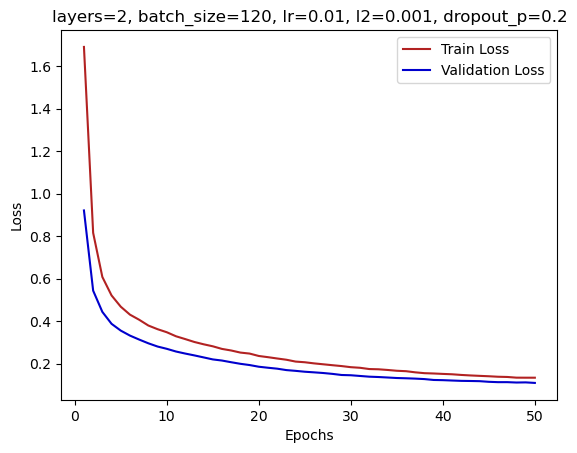

In [33]:
layers = 2
batch_size = 120
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.76953, Train Acc: 78.76% |            Validation Loss: 1.00644, Validation Acc: 78.72%
Epoch: 10 | Train Loss: 0.30629, Train Acc: 91.67% |            Validation Loss: 0.31019, Validation Acc: 91.11%
Epoch: 20 | Train Loss: 0.25904, Train Acc: 93.03% |            Validation Loss: 0.26559, Validation Acc: 92.36%
Epoch: 30 | Train Loss: 0.22355, Train Acc: 94.01% |            Validation Loss: 0.23553, Validation Acc: 93.34%
Epoch: 40 | Train Loss: 0.19952, Train Acc: 94.76% |            Validation Loss: 0.21345, Validation Acc: 94.12%


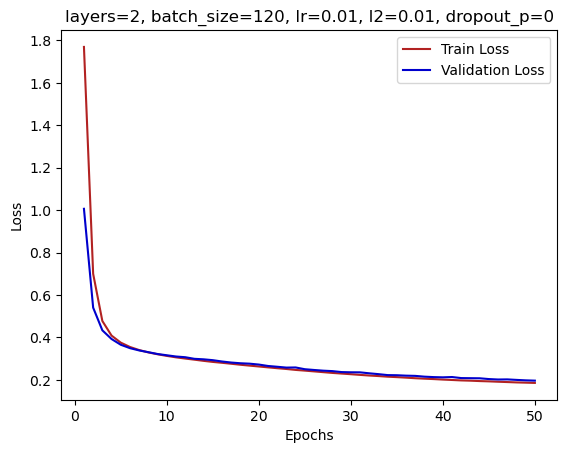

In [34]:
layers = 2
batch_size = 120
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.79871, Train Acc: 76.35% |            Validation Loss: 1.03856, Validation Acc: 76.42%
Epoch: 10 | Train Loss: 0.36943, Train Acc: 91.95% |            Validation Loss: 0.29361, Validation Acc: 91.46%
Epoch: 20 | Train Loss: 0.30247, Train Acc: 93.56% |            Validation Loss: 0.24080, Validation Acc: 93.01%
Epoch: 30 | Train Loss: 0.26517, Train Acc: 94.51% |            Validation Loss: 0.21219, Validation Acc: 93.97%
Epoch: 40 | Train Loss: 0.24583, Train Acc: 94.95% |            Validation Loss: 0.19772, Validation Acc: 94.38%


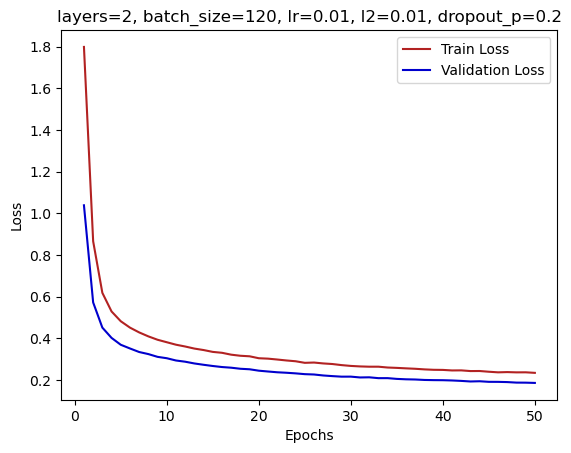

In [35]:
layers = 2
batch_size = 120
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

#### 3 Layers, Mini Batch Size 30

Epoch: 0 | Train Loss: 2.27515, Train Acc: 42.15% |            Validation Loss: 2.24069, Validation Acc: 41.59%
Epoch: 10 | Train Loss: 0.41223, Train Acc: 88.60% |            Validation Loss: 0.40411, Validation Acc: 88.21%
Epoch: 20 | Train Loss: 0.30002, Train Acc: 91.55% |            Validation Loss: 0.30613, Validation Acc: 91.18%
Epoch: 30 | Train Loss: 0.24590, Train Acc: 93.09% |            Validation Loss: 0.25384, Validation Acc: 92.64%
Epoch: 40 | Train Loss: 0.20044, Train Acc: 94.37% |            Validation Loss: 0.21400, Validation Acc: 93.67%


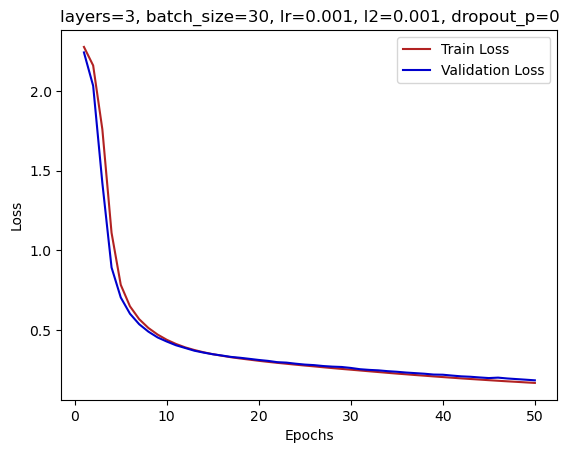

In [36]:
layers = 3
batch_size = 30
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.28947, Train Acc: 20.47% |            Validation Loss: 2.26072, Validation Acc: 20.20%
Epoch: 10 | Train Loss: 0.61469, Train Acc: 87.14% |            Validation Loss: 0.45325, Validation Acc: 86.87%
Epoch: 20 | Train Loss: 0.40549, Train Acc: 91.24% |            Validation Loss: 0.30521, Validation Acc: 90.79%
Epoch: 30 | Train Loss: 0.32470, Train Acc: 93.16% |            Validation Loss: 0.24385, Validation Acc: 92.62%
Epoch: 40 | Train Loss: 0.27151, Train Acc: 94.33% |            Validation Loss: 0.20409, Validation Acc: 93.88%


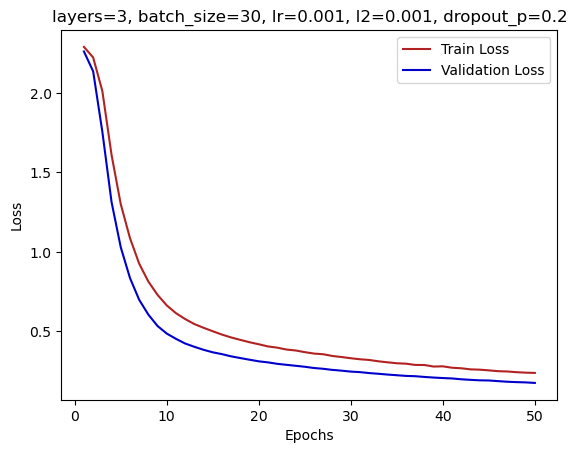

In [37]:
layers = 3
batch_size = 30
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.28433, Train Acc: 37.43% |            Validation Loss: 2.25761, Validation Acc: 37.99%
Epoch: 10 | Train Loss: 0.43112, Train Acc: 88.23% |            Validation Loss: 0.42316, Validation Acc: 88.05%
Epoch: 20 | Train Loss: 0.33953, Train Acc: 90.40% |            Validation Loss: 0.34273, Validation Acc: 90.22%
Epoch: 30 | Train Loss: 0.30508, Train Acc: 91.56% |            Validation Loss: 0.31038, Validation Acc: 91.14%
Epoch: 40 | Train Loss: 0.27842, Train Acc: 92.28% |            Validation Loss: 0.28602, Validation Acc: 91.67%


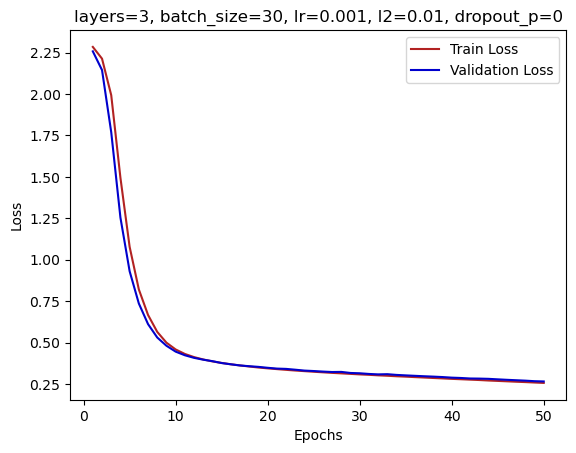

In [38]:
layers = 3
batch_size = 30
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.28876, Train Acc: 16.73% |            Validation Loss: 2.25694, Validation Acc: 16.90%
Epoch: 10 | Train Loss: 0.62968, Train Acc: 86.95% |            Validation Loss: 0.46987, Validation Acc: 86.89%
Epoch: 20 | Train Loss: 0.45140, Train Acc: 90.46% |            Validation Loss: 0.33994, Validation Acc: 90.18%
Epoch: 30 | Train Loss: 0.38284, Train Acc: 92.01% |            Validation Loss: 0.28800, Validation Acc: 91.37%
Epoch: 40 | Train Loss: 0.33440, Train Acc: 93.11% |            Validation Loss: 0.24962, Validation Acc: 92.69%


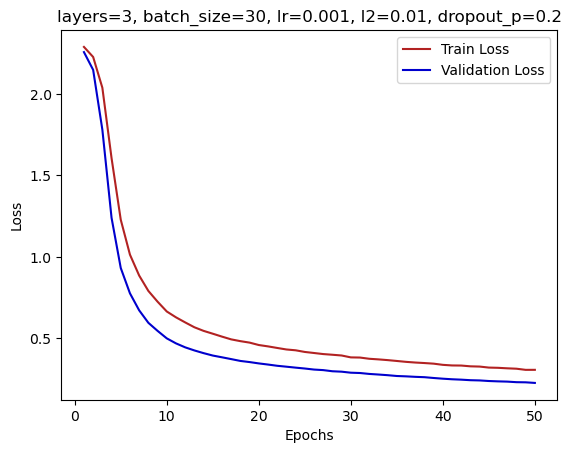

In [39]:
layers = 3
batch_size = 30
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.11703, Train Acc: 87.16% |            Validation Loss: 0.43512, Validation Acc: 87.08%
Epoch: 10 | Train Loss: 0.10388, Train Acc: 97.24% |            Validation Loss: 0.12651, Validation Acc: 96.14%
Epoch: 20 | Train Loss: 0.05458, Train Acc: 98.26% |            Validation Loss: 0.10612, Validation Acc: 96.83%
Epoch: 30 | Train Loss: 0.03386, Train Acc: 99.38% |            Validation Loss: 0.07876, Validation Acc: 97.52%
Early stopping at epoch 40, with 0.07599 validation loss


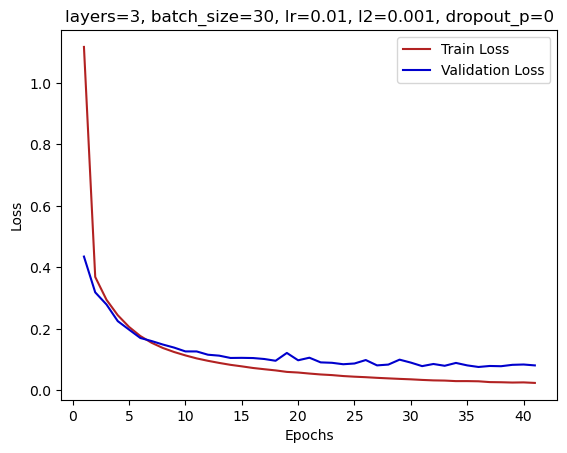

In [40]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.35187, Train Acc: 86.38% |            Validation Loss: 0.47673, Validation Acc: 86.24%
Epoch: 10 | Train Loss: 0.15745, Train Acc: 97.07% |            Validation Loss: 0.12562, Validation Acc: 96.27%
Epoch: 20 | Train Loss: 0.10466, Train Acc: 98.34% |            Validation Loss: 0.09295, Validation Acc: 97.08%
Epoch: 30 | Train Loss: 0.08071, Train Acc: 98.94% |            Validation Loss: 0.08534, Validation Acc: 97.32%
Epoch: 40 | Train Loss: 0.07022, Train Acc: 99.17% |            Validation Loss: 0.08044, Validation Acc: 97.45%


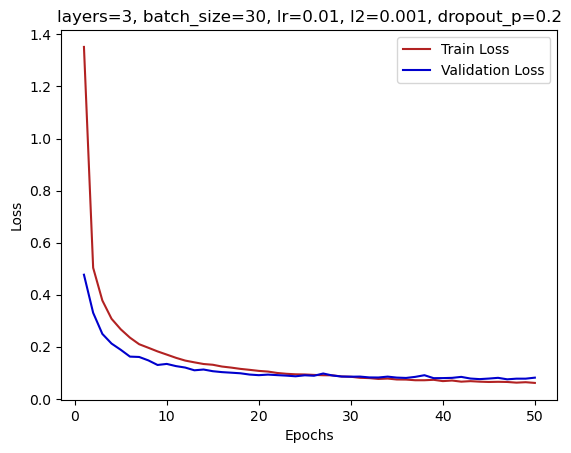

In [41]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.16262, Train Acc: 84.58% |            Validation Loss: 0.49939, Validation Acc: 84.27%
Epoch: 10 | Train Loss: 0.18913, Train Acc: 95.11% |            Validation Loss: 0.19330, Validation Acc: 94.46%
Early stopping at epoch 20, with 0.16330 validation loss


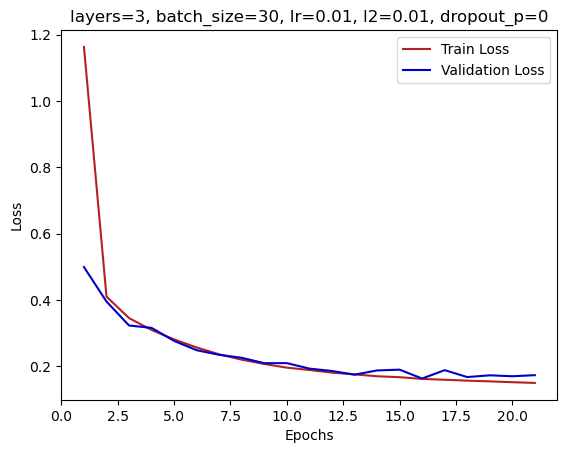

In [42]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.40026, Train Acc: 86.49% |            Validation Loss: 0.50520, Validation Acc: 86.40%
Epoch: 10 | Train Loss: 0.25278, Train Acc: 95.24% |            Validation Loss: 0.19242, Validation Acc: 94.47%
Epoch: 20 | Train Loss: 0.21514, Train Acc: 96.04% |            Validation Loss: 0.16173, Validation Acc: 95.22%
Early stopping at epoch 29, with 0.15406 validation loss


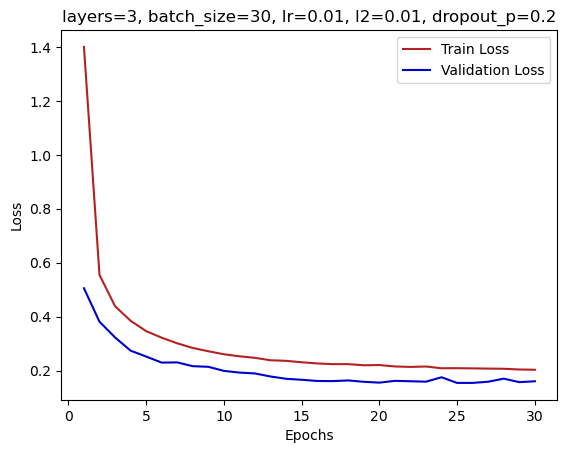

In [43]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

#### 3 Layers, Mini Batch Size 120

Epoch: 0 | Train Loss: 2.29850, Train Acc: 12.12% |            Validation Loss: 2.29172, Validation Acc: 11.30%
Epoch: 10 | Train Loss: 1.67066, Train Acc: 55.32% |            Validation Loss: 1.58793, Validation Acc: 54.59%
Epoch: 20 | Train Loss: 0.60355, Train Acc: 83.87% |            Validation Loss: 0.59233, Validation Acc: 83.74%
Epoch: 30 | Train Loss: 0.44040, Train Acc: 87.62% |            Validation Loss: 0.44061, Validation Acc: 87.21%
Epoch: 40 | Train Loss: 0.38603, Train Acc: 89.14% |            Validation Loss: 0.38833, Validation Acc: 88.88%


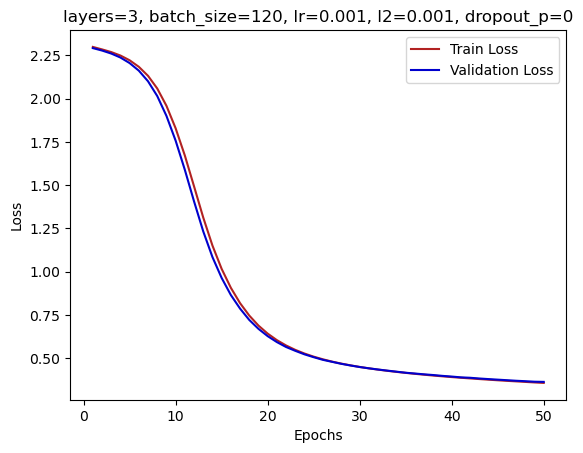

In [44]:
layers = 3
batch_size = 120
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30791, Train Acc: 9.87% |            Validation Loss: 2.30328, Validation Acc: 10.14%
Epoch: 10 | Train Loss: 2.06862, Train Acc: 45.40% |            Validation Loss: 1.99151, Validation Acc: 44.48%
Epoch: 20 | Train Loss: 1.13108, Train Acc: 75.12% |            Validation Loss: 0.93267, Validation Acc: 74.80%
Epoch: 30 | Train Loss: 0.77600, Train Acc: 83.00% |            Validation Loss: 0.60249, Validation Acc: 82.81%
Epoch: 40 | Train Loss: 0.63003, Train Acc: 86.57% |            Validation Loss: 0.47662, Validation Acc: 86.21%


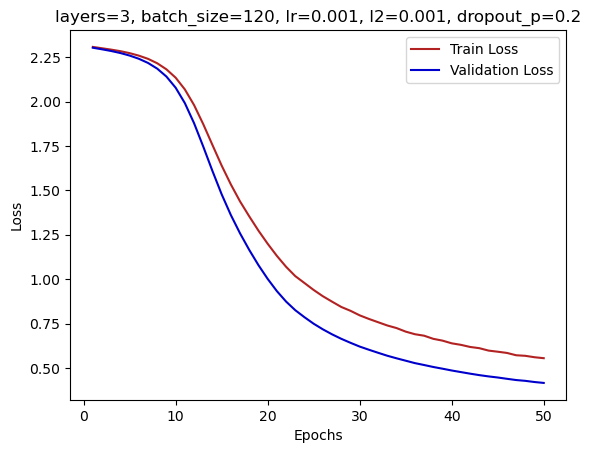

In [45]:
layers = 3
batch_size = 120
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30631, Train Acc: 9.81% |            Validation Loss: 2.29899, Validation Acc: 9.53%
Epoch: 10 | Train Loss: 1.69175, Train Acc: 53.42% |            Validation Loss: 1.60954, Validation Acc: 53.21%
Epoch: 20 | Train Loss: 0.71400, Train Acc: 80.08% |            Validation Loss: 0.70266, Validation Acc: 79.95%
Epoch: 30 | Train Loss: 0.50192, Train Acc: 85.82% |            Validation Loss: 0.49987, Validation Acc: 85.56%
Epoch: 40 | Train Loss: 0.42762, Train Acc: 88.04% |            Validation Loss: 0.42888, Validation Acc: 87.88%


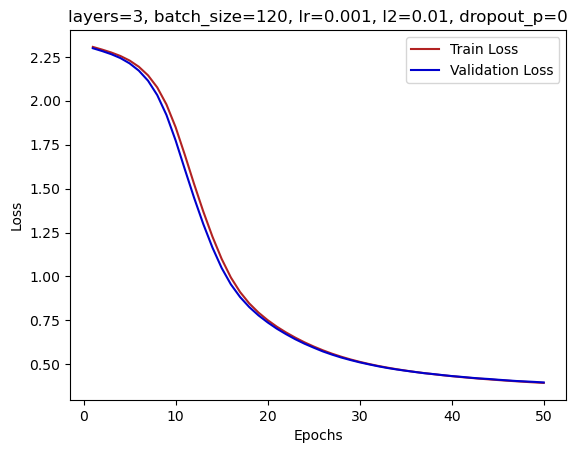

In [46]:
layers = 3
batch_size = 120
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30502, Train Acc: 10.35% |            Validation Loss: 2.30232, Validation Acc: 9.71%
Epoch: 10 | Train Loss: 2.12220, Train Acc: 41.49% |            Validation Loss: 2.06342, Validation Acc: 41.68%
Epoch: 20 | Train Loss: 1.31798, Train Acc: 67.23% |            Validation Loss: 1.14591, Validation Acc: 67.43%
Epoch: 30 | Train Loss: 0.90663, Train Acc: 80.42% |            Validation Loss: 0.73605, Validation Acc: 80.33%
Epoch: 40 | Train Loss: 0.71988, Train Acc: 85.08% |            Validation Loss: 0.56129, Validation Acc: 84.88%


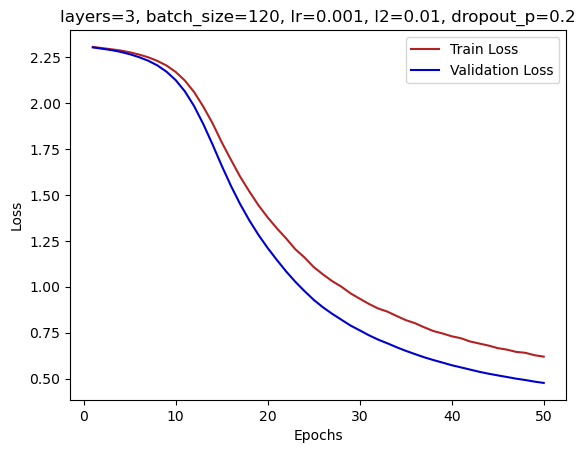

In [47]:
layers = 3
batch_size = 120
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.14751, Train Acc: 54.61% |            Validation Loss: 1.72355, Validation Acc: 54.19%
Epoch: 10 | Train Loss: 0.26416, Train Acc: 92.69% |            Validation Loss: 0.26449, Validation Acc: 92.20%
Epoch: 20 | Train Loss: 0.16824, Train Acc: 95.32% |            Validation Loss: 0.18124, Validation Acc: 94.67%
Epoch: 30 | Train Loss: 0.11759, Train Acc: 96.77% |            Validation Loss: 0.14265, Validation Acc: 95.64%
Epoch: 40 | Train Loss: 0.08844, Train Acc: 97.65% |            Validation Loss: 0.11869, Validation Acc: 96.23%


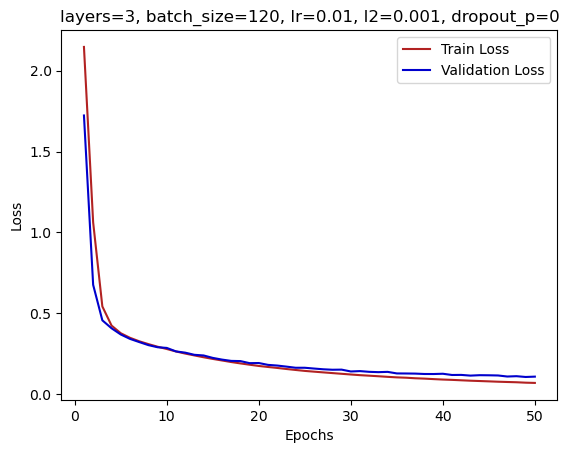

In [48]:
layers = 3
batch_size = 120
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.23801, Train Acc: 42.74% |            Validation Loss: 2.04715, Validation Acc: 42.36%
Epoch: 10 | Train Loss: 0.35840, Train Acc: 92.61% |            Validation Loss: 0.26309, Validation Acc: 92.18%
Epoch: 20 | Train Loss: 0.22993, Train Acc: 95.52% |            Validation Loss: 0.16929, Validation Acc: 94.97%
Epoch: 30 | Train Loss: 0.17187, Train Acc: 96.88% |            Validation Loss: 0.13290, Validation Acc: 95.99%
Epoch: 40 | Train Loss: 0.13967, Train Acc: 97.66% |            Validation Loss: 0.11279, Validation Acc: 96.55%


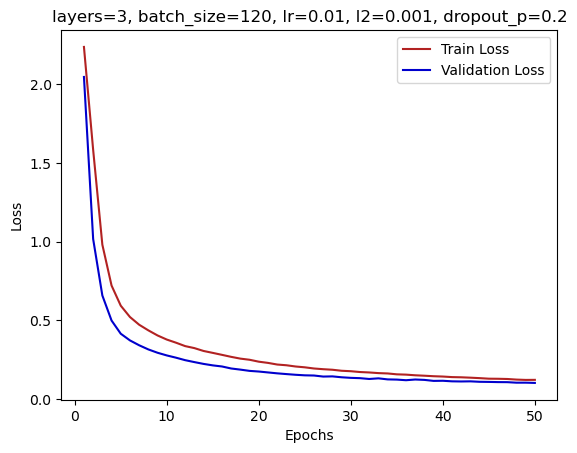

In [49]:
layers = 3
batch_size = 120
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.18804, Train Acc: 42.30% |            Validation Loss: 1.89308, Validation Acc: 42.38%
Epoch: 10 | Train Loss: 0.31135, Train Acc: 91.60% |            Validation Loss: 0.30923, Validation Acc: 91.22%
Epoch: 20 | Train Loss: 0.24164, Train Acc: 93.50% |            Validation Loss: 0.24710, Validation Acc: 92.90%
Epoch: 30 | Train Loss: 0.20055, Train Acc: 94.82% |            Validation Loss: 0.20950, Validation Acc: 94.11%
Epoch: 40 | Train Loss: 0.17726, Train Acc: 95.39% |            Validation Loss: 0.19265, Validation Acc: 94.77%


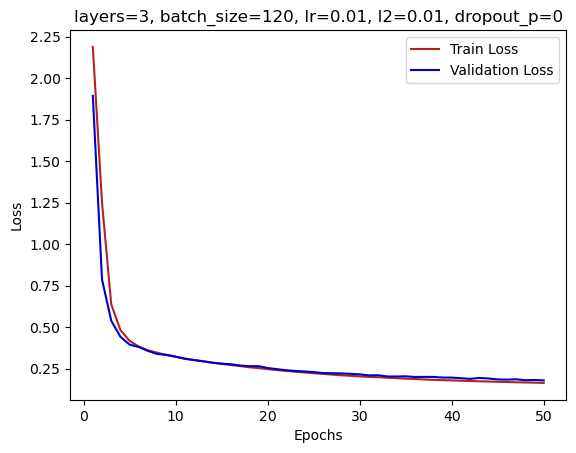

In [50]:
layers = 3
batch_size = 120
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.20884, Train Acc: 36.50% |            Validation Loss: 1.94345, Validation Acc: 36.62%
Epoch: 10 | Train Loss: 0.42682, Train Acc: 91.12% |            Validation Loss: 0.32066, Validation Acc: 90.88%
Epoch: 20 | Train Loss: 0.31281, Train Acc: 93.88% |            Validation Loss: 0.23092, Validation Acc: 93.38%
Epoch: 30 | Train Loss: 0.26125, Train Acc: 94.99% |            Validation Loss: 0.19379, Validation Acc: 94.49%
Epoch: 40 | Train Loss: 0.23715, Train Acc: 95.65% |            Validation Loss: 0.17622, Validation Acc: 94.94%


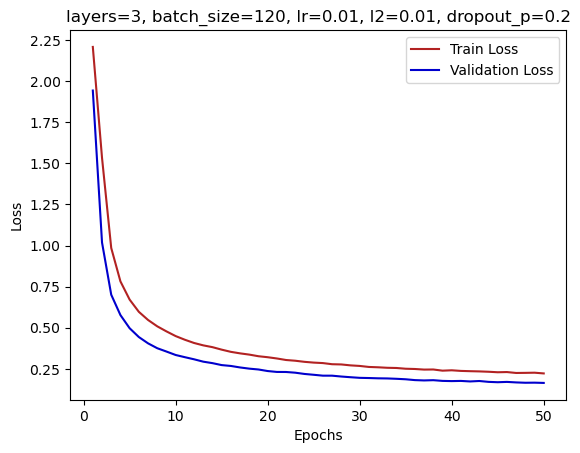

In [51]:
layers = 3
batch_size = 120
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

### Stochatic Gradient Descet

In [57]:
def ModelTraining(layers, batch_size, lr, l2, dropout_p, patience=5, epochs_per_print = 10, num_epochs = 50):
    
    if layers == 2:
        model = BaseModel2(dropout_p)
    else:
        model = BaseModel3(dropout_p)
             
    #Lists of loss per epoch
    train_losses = []
    valid_losses = []
    
    #Loaders
    validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    
    #Size of train subset
    train_set_size = len(train_subset)

    #Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2)
    
    #Early stopping improvment constant 
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    best_valid_acc = 0
    
    #Training loop
    for epoch in range(num_epochs):

        model.train()
        total_loss_train = 0
        
        for batch_idx, (data, target) in enumerate(trainloader):

            output_train = model(data)
            loss_train = loss_fn(output_train, target)
            total_loss_train += loss_train
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
        #Train loss average in current epoch
        total_loss_train /= (train_set_size/batch_size)
        train_losses.append(total_loss_train)
        
        #Evaluation
        model.eval()
        with torch.inference_mode():
            
            #Accuracy and loss in valid
            for batch_idx, (data_valid, target_valid) in enumerate(validloader):
                output_valid = model(data_valid)
                pred_valid = torch.softmax(output_valid, dim=1).argmax(dim=1)
                loss_valid = loss_fn(output_valid, target_valid)
                acc_valid = accuracy_fn(target_valid, pred_valid)
                
            valid_losses.append(loss_valid)
            
            #Early stopping
            if loss_valid < best_valid_loss:
                best_valid_loss = loss_valid
                epochs_no_improve = 0
                
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch}, with {best_valid_loss:.5f} validation loss')
                    break
            
        #acc in train
        total_acc_train = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            output_train = model(data)
            pred_train = torch.softmax(output_train, dim=1).argmax(dim=1)
            total_acc_train += accuracy_fn(target, pred_train)
                
        total_acc_train /= (train_set_size/batch_size)
            
        print(f"Epoch: {epoch} | Train Loss: {total_loss_train:.5f}, Train Acc: {total_acc_train:.2f}% |\
        Validation Loss: {loss_valid:.5f}, Validation Acc: {acc_valid:.2f}%")
            
    return train_losses, valid_losses

In [58]:
num_epochs = 10

Epoch: 0 | Train Loss: 0.49452, Train Acc: 91.83% |        Validation Loss: 0.28783, Validation Acc: 91.07%
Epoch: 1 | Train Loss: 0.23233, Train Acc: 94.67% |        Validation Loss: 0.19561, Validation Acc: 94.27%
Epoch: 2 | Train Loss: 0.16788, Train Acc: 95.11% |        Validation Loss: 0.18883, Validation Acc: 94.07%
Epoch: 3 | Train Loss: 0.13480, Train Acc: 96.81% |        Validation Loss: 0.13451, Validation Acc: 96.03%
Epoch: 4 | Train Loss: 0.11397, Train Acc: 97.30% |        Validation Loss: 0.11785, Validation Acc: 96.42%
Epoch: 5 | Train Loss: 0.09837, Train Acc: 97.08% |        Validation Loss: 0.12937, Validation Acc: 96.17%
Epoch: 6 | Train Loss: 0.08686, Train Acc: 97.98% |        Validation Loss: 0.10067, Validation Acc: 96.80%
Epoch: 7 | Train Loss: 0.07866, Train Acc: 97.94% |        Validation Loss: 0.10084, Validation Acc: 96.80%
Epoch: 8 | Train Loss: 0.07234, Train Acc: 98.44% |        Validation Loss: 0.09073, Validation Acc: 97.07%
Epoch: 9 | Train Loss: 0.065

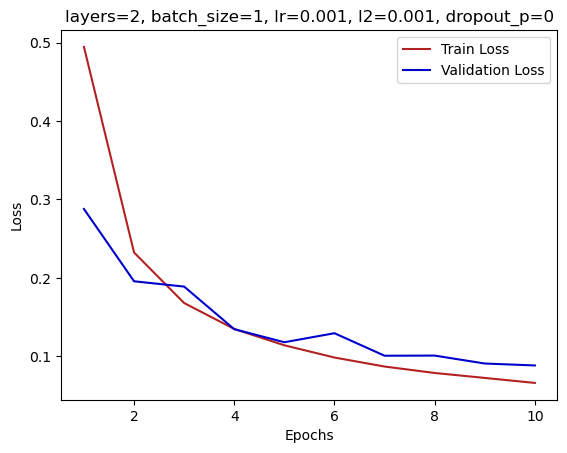

In [59]:
layers = 2
batch_size = 1
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.60959, Train Acc: 92.27% |        Validation Loss: 0.26766, Validation Acc: 91.90%
Epoch: 1 | Train Loss: 0.29820, Train Acc: 93.53% |        Validation Loss: 0.22162, Validation Acc: 93.32%
Epoch: 2 | Train Loss: 0.22878, Train Acc: 95.39% |        Validation Loss: 0.17076, Validation Acc: 94.93%
Epoch: 3 | Train Loss: 0.19301, Train Acc: 96.45% |        Validation Loss: 0.13717, Validation Acc: 95.80%
Epoch: 4 | Train Loss: 0.17010, Train Acc: 96.65% |        Validation Loss: 0.13072, Validation Acc: 95.90%
Epoch: 5 | Train Loss: 0.15607, Train Acc: 97.12% |        Validation Loss: 0.11885, Validation Acc: 96.40%
Epoch: 6 | Train Loss: 0.14368, Train Acc: 97.46% |        Validation Loss: 0.11447, Validation Acc: 96.68%
Epoch: 7 | Train Loss: 0.13079, Train Acc: 97.34% |        Validation Loss: 0.11700, Validation Acc: 96.52%
Epoch: 8 | Train Loss: 0.12645, Train Acc: 98.05% |        Validation Loss: 0.09609, Validation Acc: 96.97%
Epoch: 9 | Train Loss: 0.120

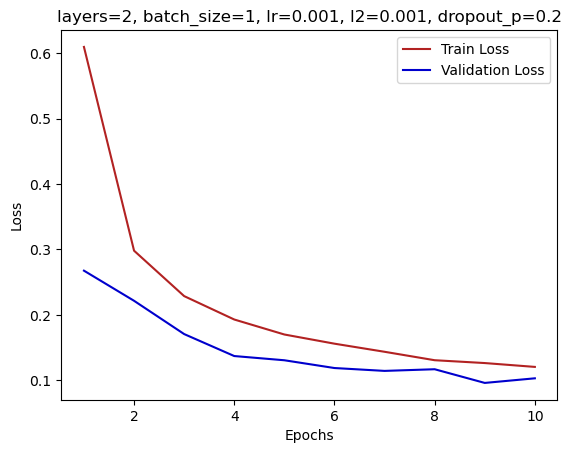

In [60]:
layers = 2
batch_size = 1
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.52279, Train Acc: 91.19% |        Validation Loss: 0.31332, Validation Acc: 90.85%
Epoch: 1 | Train Loss: 0.29055, Train Acc: 93.28% |        Validation Loss: 0.25194, Validation Acc: 92.67%
Epoch: 2 | Train Loss: 0.24544, Train Acc: 93.48% |        Validation Loss: 0.24127, Validation Acc: 92.97%
Epoch: 3 | Train Loss: 0.21899, Train Acc: 94.74% |        Validation Loss: 0.20472, Validation Acc: 94.42%
Epoch: 4 | Train Loss: 0.20447, Train Acc: 94.10% |        Validation Loss: 0.22334, Validation Acc: 93.66%
Epoch: 5 | Train Loss: 0.19518, Train Acc: 94.77% |        Validation Loss: 0.21230, Validation Acc: 94.23%
Epoch: 6 | Train Loss: 0.18942, Train Acc: 95.16% |        Validation Loss: 0.19315, Validation Acc: 94.60%
Epoch: 7 | Train Loss: 0.18358, Train Acc: 94.73% |        Validation Loss: 0.20808, Validation Acc: 94.33%
Epoch: 8 | Train Loss: 0.18065, Train Acc: 95.86% |        Validation Loss: 0.17345, Validation Acc: 95.27%
Epoch: 9 | Train Loss: 0.178

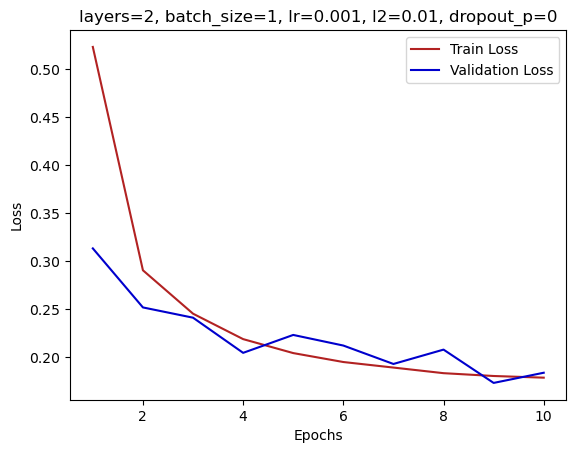

In [61]:
layers = 2
batch_size = 1
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.65780, Train Acc: 90.82% |        Validation Loss: 0.32413, Validation Acc: 90.40%
Epoch: 1 | Train Loss: 0.35684, Train Acc: 92.43% |        Validation Loss: 0.26065, Validation Acc: 92.18%
Epoch: 2 | Train Loss: 0.30905, Train Acc: 93.97% |        Validation Loss: 0.22593, Validation Acc: 93.76%
Epoch: 3 | Train Loss: 0.28422, Train Acc: 94.51% |        Validation Loss: 0.20866, Validation Acc: 94.34%
Epoch: 4 | Train Loss: 0.26557, Train Acc: 93.99% |        Validation Loss: 0.22218, Validation Acc: 93.77%
Epoch: 5 | Train Loss: 0.25584, Train Acc: 95.00% |        Validation Loss: 0.19086, Validation Acc: 94.59%
Epoch: 6 | Train Loss: 0.25432, Train Acc: 94.70% |        Validation Loss: 0.20116, Validation Acc: 94.11%
Epoch: 7 | Train Loss: 0.24549, Train Acc: 95.10% |        Validation Loss: 0.19413, Validation Acc: 94.43%
Epoch: 8 | Train Loss: 0.24072, Train Acc: 95.23% |        Validation Loss: 0.18908, Validation Acc: 94.64%
Epoch: 9 | Train Loss: 0.239

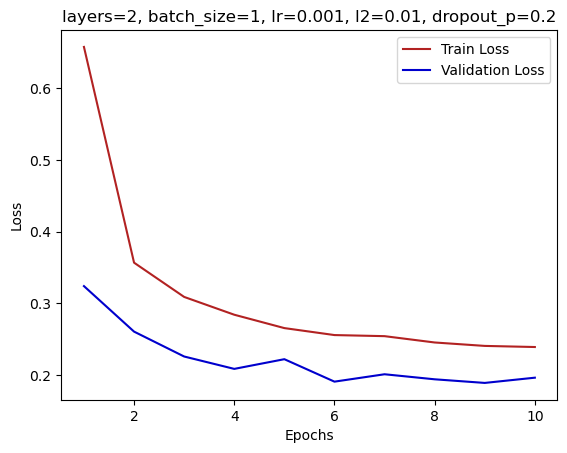

In [62]:
layers = 2
batch_size = 1
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.38418, Train Acc: 94.88% |        Validation Loss: 0.19144, Validation Acc: 94.60%
Epoch: 1 | Train Loss: 0.23083, Train Acc: 94.65% |        Validation Loss: 0.20655, Validation Acc: 93.93%
Epoch: 2 | Train Loss: 0.20396, Train Acc: 93.32% |        Validation Loss: 0.25024, Validation Acc: 92.50%
Epoch: 3 | Train Loss: 0.18382, Train Acc: 95.90% |        Validation Loss: 0.16954, Validation Acc: 94.82%
Epoch: 4 | Train Loss: 0.18173, Train Acc: 94.80% |        Validation Loss: 0.18894, Validation Acc: 94.47%
Epoch: 5 | Train Loss: 0.17487, Train Acc: 96.38% |        Validation Loss: 0.14085, Validation Acc: 95.62%
Epoch: 6 | Train Loss: 0.17341, Train Acc: 94.29% |        Validation Loss: 0.21105, Validation Acc: 93.24%
Epoch: 7 | Train Loss: 0.17041, Train Acc: 94.58% |        Validation Loss: 0.19657, Validation Acc: 93.99%
Epoch: 8 | Train Loss: 0.16562, Train Acc: 94.75% |        Validation Loss: 0.19652, Validation Acc: 94.12%
Epoch: 9 | Train Loss: 0.165

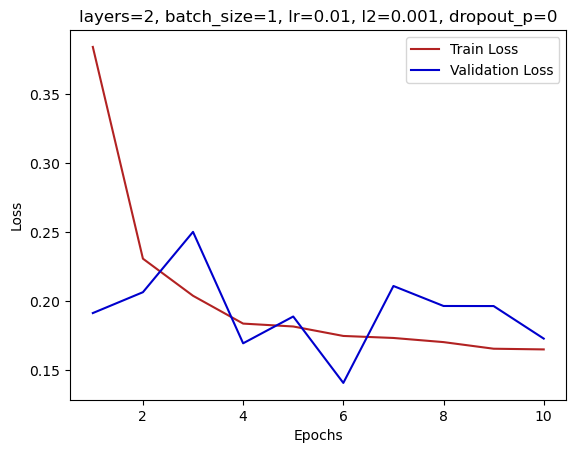

In [63]:
layers = 2
batch_size = 1
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.56970, Train Acc: 92.72% |        Validation Loss: 0.26117, Validation Acc: 92.18%
Epoch: 1 | Train Loss: 0.38814, Train Acc: 93.26% |        Validation Loss: 0.24869, Validation Acc: 92.78%
Epoch: 2 | Train Loss: 0.35387, Train Acc: 92.05% |        Validation Loss: 0.26939, Validation Acc: 91.75%
Epoch: 3 | Train Loss: 0.33522, Train Acc: 93.25% |        Validation Loss: 0.25221, Validation Acc: 92.64%
Epoch: 4 | Train Loss: 0.33155, Train Acc: 94.03% |        Validation Loss: 0.21389, Validation Acc: 93.67%
Epoch: 5 | Train Loss: 0.33037, Train Acc: 92.12% |        Validation Loss: 0.28214, Validation Acc: 91.84%
Epoch: 6 | Train Loss: 0.32228, Train Acc: 93.45% |        Validation Loss: 0.23693, Validation Acc: 92.96%
Epoch: 7 | Train Loss: 0.31608, Train Acc: 89.82% |        Validation Loss: 0.38949, Validation Acc: 89.01%
Epoch: 8 | Train Loss: 0.31624, Train Acc: 93.61% |        Validation Loss: 0.24077, Validation Acc: 93.16%
Early stopping at epoch 9, w

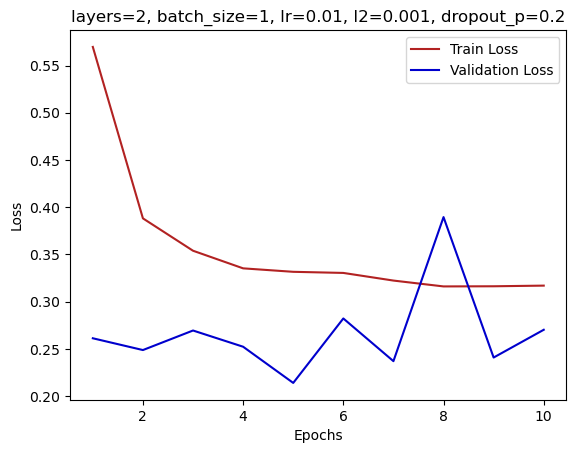

In [64]:
layers = 2
batch_size = 1
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.47403, Train Acc: 90.26% |        Validation Loss: 0.35145, Validation Acc: 89.77%
Epoch: 1 | Train Loss: 0.38969, Train Acc: 90.61% |        Validation Loss: 0.30646, Validation Acc: 90.76%
Epoch: 2 | Train Loss: 0.38444, Train Acc: 89.32% |        Validation Loss: 0.33630, Validation Acc: 88.95%
Epoch: 3 | Train Loss: 0.37909, Train Acc: 91.35% |        Validation Loss: 0.31126, Validation Acc: 90.80%
Epoch: 4 | Train Loss: 0.38383, Train Acc: 89.28% |        Validation Loss: 0.33940, Validation Acc: 89.17%
Epoch: 5 | Train Loss: 0.38155, Train Acc: 87.51% |        Validation Loss: 0.39131, Validation Acc: 87.49%
Epoch: 6 | Train Loss: 0.38075, Train Acc: 91.23% |        Validation Loss: 0.28425, Validation Acc: 90.88%
Epoch: 7 | Train Loss: 0.37880, Train Acc: 90.30% |        Validation Loss: 0.32321, Validation Acc: 90.12%
Epoch: 8 | Train Loss: 0.37770, Train Acc: 89.81% |        Validation Loss: 0.37340, Validation Acc: 89.37%
Epoch: 9 | Train Loss: 0.378

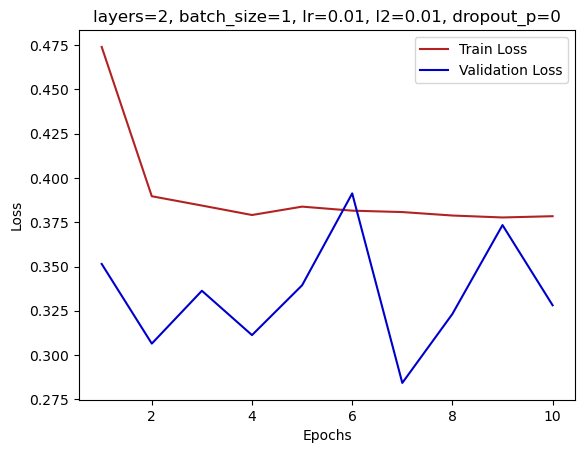

In [65]:
layers = 2
batch_size = 1
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.65394, Train Acc: 87.46% |        Validation Loss: 0.43635, Validation Acc: 87.28%
Epoch: 1 | Train Loss: 0.57274, Train Acc: 69.17% |        Validation Loss: 0.90788, Validation Acc: 69.52%
Epoch: 2 | Train Loss: 0.57559, Train Acc: 89.38% |        Validation Loss: 0.35329, Validation Acc: 89.38%
Epoch: 3 | Train Loss: 0.57390, Train Acc: 83.34% |        Validation Loss: 0.51155, Validation Acc: 83.12%
Epoch: 4 | Train Loss: 0.57563, Train Acc: 88.45% |        Validation Loss: 0.43081, Validation Acc: 88.15%
Epoch: 5 | Train Loss: 0.57504, Train Acc: 88.04% |        Validation Loss: 0.44586, Validation Acc: 88.07%
Epoch: 6 | Train Loss: 0.58127, Train Acc: 82.50% |        Validation Loss: 0.51876, Validation Acc: 82.31%
Early stopping at epoch 7, with 0.35329 validation loss


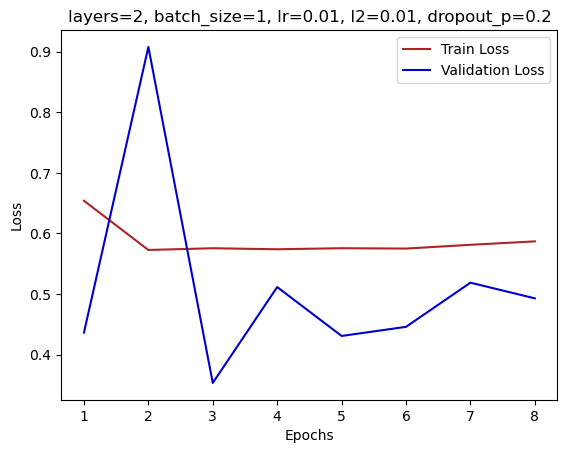

In [66]:
layers = 2
batch_size = 1
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.60036, Train Acc: 92.01% |        Validation Loss: 0.27672, Validation Acc: 91.28%
Epoch: 1 | Train Loss: 0.23180, Train Acc: 94.79% |        Validation Loss: 0.18968, Validation Acc: 94.26%
Epoch: 2 | Train Loss: 0.16715, Train Acc: 96.04% |        Validation Loss: 0.15601, Validation Acc: 95.12%
Epoch: 3 | Train Loss: 0.13173, Train Acc: 96.71% |        Validation Loss: 0.13822, Validation Acc: 95.68%
Epoch: 4 | Train Loss: 0.11112, Train Acc: 97.20% |        Validation Loss: 0.12511, Validation Acc: 96.20%
Epoch: 5 | Train Loss: 0.09468, Train Acc: 97.32% |        Validation Loss: 0.11933, Validation Acc: 96.33%
Epoch: 6 | Train Loss: 0.08474, Train Acc: 97.79% |        Validation Loss: 0.10825, Validation Acc: 96.71%
Epoch: 7 | Train Loss: 0.07578, Train Acc: 98.52% |        Validation Loss: 0.09075, Validation Acc: 97.12%
Epoch: 8 | Train Loss: 0.06844, Train Acc: 96.60% |        Validation Loss: 0.14593, Validation Acc: 95.47%
Epoch: 9 | Train Loss: 0.062

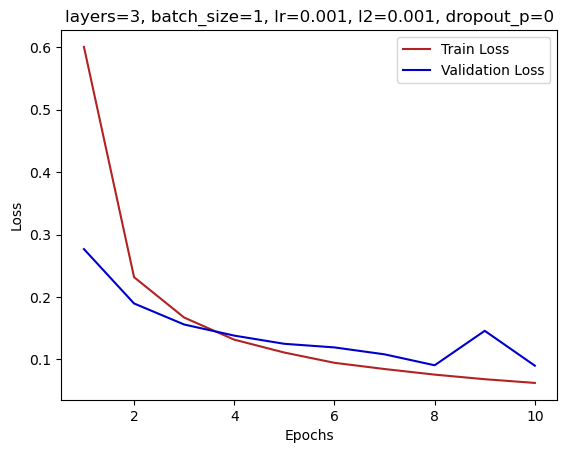

In [67]:
layers = 3
batch_size = 1
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.78539, Train Acc: 90.45% |        Validation Loss: 0.31726, Validation Acc: 90.29%
Epoch: 1 | Train Loss: 0.32953, Train Acc: 94.41% |        Validation Loss: 0.20511, Validation Acc: 93.88%
Epoch: 2 | Train Loss: 0.25077, Train Acc: 95.40% |        Validation Loss: 0.16939, Validation Acc: 94.75%
Epoch: 3 | Train Loss: 0.21232, Train Acc: 95.49% |        Validation Loss: 0.16697, Validation Acc: 94.68%
Epoch: 4 | Train Loss: 0.18275, Train Acc: 96.55% |        Validation Loss: 0.13880, Validation Acc: 95.83%
Epoch: 5 | Train Loss: 0.16535, Train Acc: 97.24% |        Validation Loss: 0.11921, Validation Acc: 96.34%
Epoch: 6 | Train Loss: 0.15336, Train Acc: 97.62% |        Validation Loss: 0.11036, Validation Acc: 96.66%
Epoch: 7 | Train Loss: 0.14387, Train Acc: 97.36% |        Validation Loss: 0.11475, Validation Acc: 96.46%
Epoch: 8 | Train Loss: 0.13334, Train Acc: 97.79% |        Validation Loss: 0.10494, Validation Acc: 96.69%
Epoch: 9 | Train Loss: 0.127

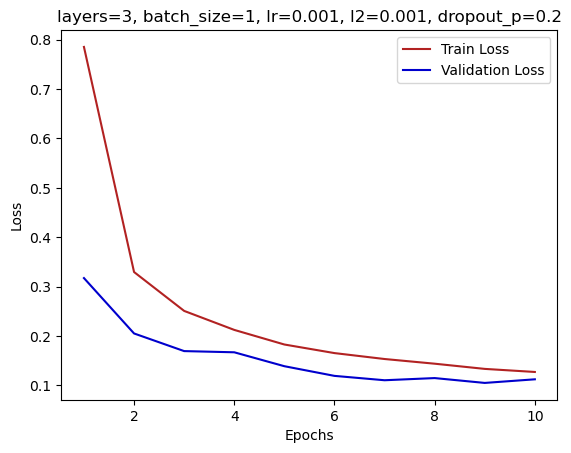

In [68]:
layers = 3
batch_size = 1
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.67073, Train Acc: 90.03% |        Validation Loss: 0.34073, Validation Acc: 89.54%
Epoch: 1 | Train Loss: 0.30473, Train Acc: 92.39% |        Validation Loss: 0.27061, Validation Acc: 92.08%
Epoch: 2 | Train Loss: 0.24504, Train Acc: 93.96% |        Validation Loss: 0.22249, Validation Acc: 93.42%
Epoch: 3 | Train Loss: 0.21711, Train Acc: 94.59% |        Validation Loss: 0.20246, Validation Acc: 94.07%
Epoch: 4 | Train Loss: 0.20036, Train Acc: 94.56% |        Validation Loss: 0.20144, Validation Acc: 93.96%
Epoch: 5 | Train Loss: 0.18970, Train Acc: 94.97% |        Validation Loss: 0.19882, Validation Acc: 94.41%
Epoch: 6 | Train Loss: 0.18375, Train Acc: 95.94% |        Validation Loss: 0.16991, Validation Acc: 95.14%
Epoch: 7 | Train Loss: 0.17713, Train Acc: 95.21% |        Validation Loss: 0.18628, Validation Acc: 94.71%
Epoch: 8 | Train Loss: 0.17484, Train Acc: 95.54% |        Validation Loss: 0.17880, Validation Acc: 94.75%
Epoch: 9 | Train Loss: 0.170

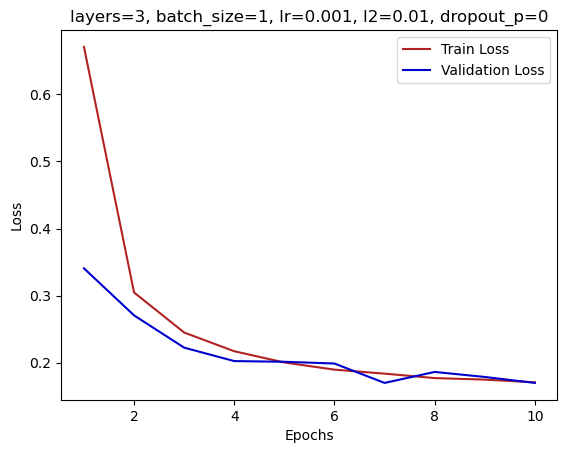

In [69]:
layers = 3
batch_size = 1
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.86855, Train Acc: 90.00% |        Validation Loss: 0.36687, Validation Acc: 89.68%
Epoch: 1 | Train Loss: 0.40024, Train Acc: 92.63% |        Validation Loss: 0.27335, Validation Acc: 92.20%
Epoch: 2 | Train Loss: 0.32628, Train Acc: 93.91% |        Validation Loss: 0.23124, Validation Acc: 93.29%
Epoch: 3 | Train Loss: 0.29281, Train Acc: 94.39% |        Validation Loss: 0.21078, Validation Acc: 93.80%
Epoch: 4 | Train Loss: 0.27769, Train Acc: 94.62% |        Validation Loss: 0.20452, Validation Acc: 94.00%
Epoch: 5 | Train Loss: 0.26557, Train Acc: 94.91% |        Validation Loss: 0.19212, Validation Acc: 94.40%
Epoch: 6 | Train Loss: 0.25794, Train Acc: 95.24% |        Validation Loss: 0.18282, Validation Acc: 94.73%
Epoch: 7 | Train Loss: 0.25124, Train Acc: 95.19% |        Validation Loss: 0.19024, Validation Acc: 94.38%
Epoch: 8 | Train Loss: 0.25009, Train Acc: 94.11% |        Validation Loss: 0.20881, Validation Acc: 93.53%
Epoch: 9 | Train Loss: 0.241

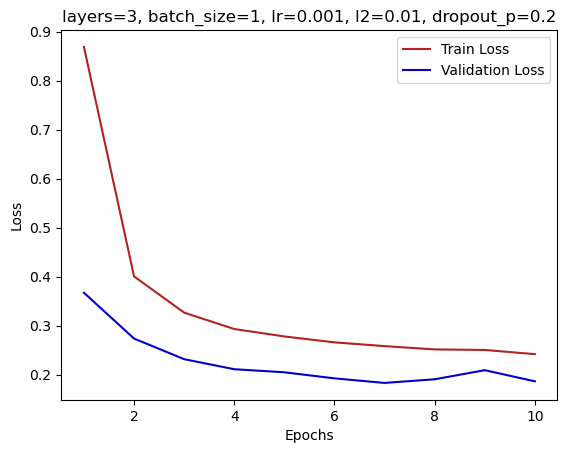

In [70]:
layers = 3
batch_size = 1
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.41748, Train Acc: 90.91% |        Validation Loss: 0.32030, Validation Acc: 90.72%
Epoch: 1 | Train Loss: 0.24056, Train Acc: 95.22% |        Validation Loss: 0.18055, Validation Acc: 94.59%
Epoch: 2 | Train Loss: 0.20557, Train Acc: 91.20% |        Validation Loss: 0.32171, Validation Acc: 90.63%
Epoch: 3 | Train Loss: 0.19663, Train Acc: 93.88% |        Validation Loss: 0.22637, Validation Acc: 93.26%
Epoch: 4 | Train Loss: 0.18799, Train Acc: 95.56% |        Validation Loss: 0.17453, Validation Acc: 95.01%
Epoch: 5 | Train Loss: 0.18342, Train Acc: 95.59% |        Validation Loss: 0.16434, Validation Acc: 94.81%
Epoch: 6 | Train Loss: 0.18146, Train Acc: 94.86% |        Validation Loss: 0.19534, Validation Acc: 94.01%
Epoch: 7 | Train Loss: 0.17566, Train Acc: 96.58% |        Validation Loss: 0.14201, Validation Acc: 95.98%
Epoch: 8 | Train Loss: 0.17330, Train Acc: 96.26% |        Validation Loss: 0.15983, Validation Acc: 95.30%
Epoch: 9 | Train Loss: 0.170

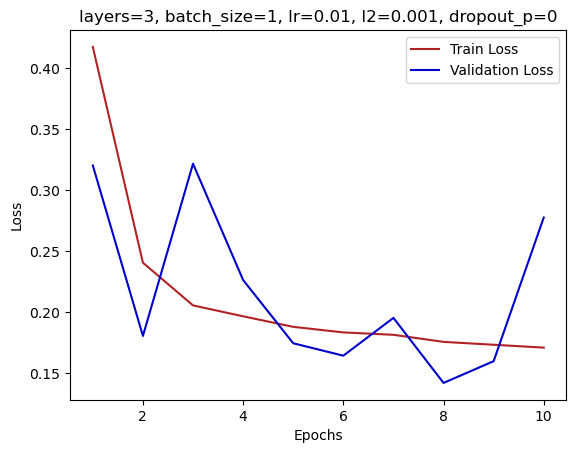

In [71]:
layers = 3
batch_size = 1
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.62603, Train Acc: 87.81% |        Validation Loss: 0.37392, Validation Acc: 87.47%
Epoch: 1 | Train Loss: 0.40871, Train Acc: 93.65% |        Validation Loss: 0.23727, Validation Acc: 93.42%
Epoch: 2 | Train Loss: 0.37218, Train Acc: 92.80% |        Validation Loss: 0.26556, Validation Acc: 92.62%
Epoch: 3 | Train Loss: 0.35362, Train Acc: 88.47% |        Validation Loss: 0.40152, Validation Acc: 87.91%
Epoch: 4 | Train Loss: 0.33902, Train Acc: 92.51% |        Validation Loss: 0.27138, Validation Acc: 91.99%
Epoch: 5 | Train Loss: 0.33494, Train Acc: 93.05% |        Validation Loss: 0.25379, Validation Acc: 92.69%
Epoch: 6 | Train Loss: 0.32811, Train Acc: 94.65% |        Validation Loss: 0.21138, Validation Acc: 93.97%
Epoch: 7 | Train Loss: 0.32875, Train Acc: 92.06% |        Validation Loss: 0.27567, Validation Acc: 91.46%
Epoch: 8 | Train Loss: 0.33026, Train Acc: 92.98% |        Validation Loss: 0.24017, Validation Acc: 92.70%
Epoch: 9 | Train Loss: 0.325

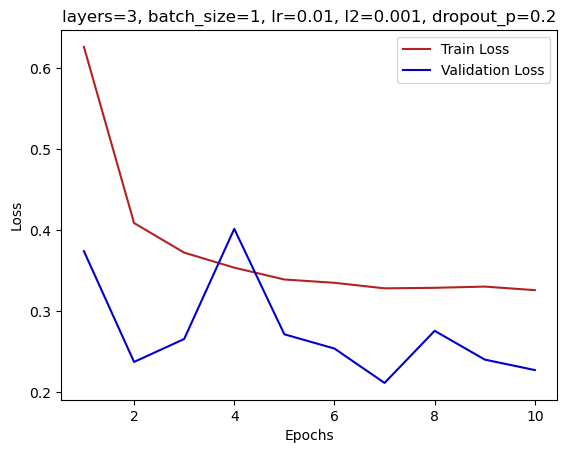

In [72]:
layers = 3
batch_size = 1
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.53036, Train Acc: 87.40% |        Validation Loss: 0.38881, Validation Acc: 87.72%
Epoch: 1 | Train Loss: 0.41787, Train Acc: 90.64% |        Validation Loss: 0.31351, Validation Acc: 90.18%
Epoch: 2 | Train Loss: 0.41160, Train Acc: 85.59% |        Validation Loss: 0.46027, Validation Acc: 85.87%
Epoch: 3 | Train Loss: 0.40750, Train Acc: 89.25% |        Validation Loss: 0.35950, Validation Acc: 89.14%
Epoch: 4 | Train Loss: 0.40609, Train Acc: 90.92% |        Validation Loss: 0.31746, Validation Acc: 90.82%
Epoch: 5 | Train Loss: 0.40882, Train Acc: 85.70% |        Validation Loss: 0.46928, Validation Acc: 85.09%
Early stopping at epoch 6, with 0.31351 validation loss


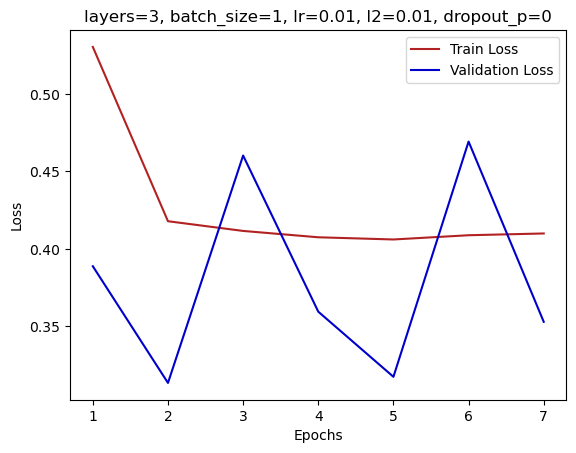

In [73]:
layers = 3
batch_size = 1
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.72592, Train Acc: 82.66% |        Validation Loss: 0.55797, Validation Acc: 82.05%
Epoch: 1 | Train Loss: 0.61686, Train Acc: 85.81% |        Validation Loss: 0.50820, Validation Acc: 85.65%
Epoch: 2 | Train Loss: 0.61720, Train Acc: 86.81% |        Validation Loss: 0.45356, Validation Acc: 86.62%
Epoch: 3 | Train Loss: 0.62268, Train Acc: 84.34% |        Validation Loss: 0.51322, Validation Acc: 84.28%
Epoch: 4 | Train Loss: 0.63027, Train Acc: 86.10% |        Validation Loss: 0.46420, Validation Acc: 86.26%
Epoch: 5 | Train Loss: 0.63386, Train Acc: 88.66% |        Validation Loss: 0.39791, Validation Acc: 88.34%
Epoch: 6 | Train Loss: 0.64446, Train Acc: 84.62% |        Validation Loss: 0.56943, Validation Acc: 84.18%
Epoch: 7 | Train Loss: 0.65458, Train Acc: 88.25% |        Validation Loss: 0.41563, Validation Acc: 88.18%
Epoch: 8 | Train Loss: 0.65594, Train Acc: 86.71% |        Validation Loss: 0.47095, Validation Acc: 86.33%
Epoch: 9 | Train Loss: 0.667

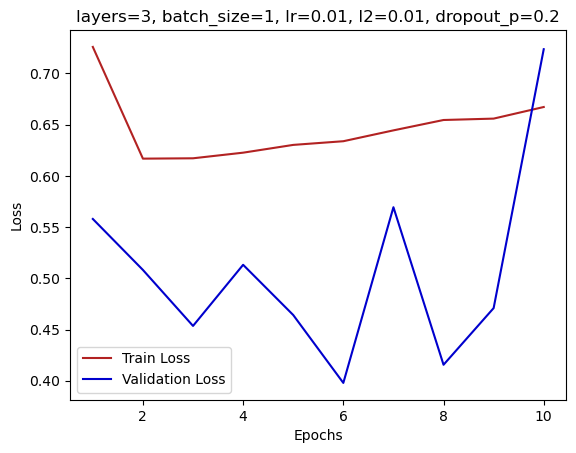

In [74]:
layers = 3
batch_size = 1
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p, num_epochs = num_epochs)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

### Batch Gradient Descet

In [77]:
def ModelTraining(layers, batch_size, lr, l2, dropout_p, patience=5, epochs_per_print = 10, num_epochs = 100):
    
    if layers == 2:
        model = BaseModel2(dropout_p)
    else:
        model = BaseModel3(dropout_p)
             
    #Lists of loss per epoch
    train_losses = []
    valid_losses = []
    
    #Loaders
    validloader = torch.utils.data.DataLoader(valid_subset, batch_size=len(valid_subset))
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    
    #Size of train subset
    train_set_size = len(train_subset)

    #Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2)
    
    #Early stopping improvment constant 
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    best_valid_acc = 0
    
    #Training loop
    for epoch in range(num_epochs):

        model.train()
        total_loss_train = 0
        
        for batch_idx, (data, target) in enumerate(trainloader):

            output_train = model(data)
            loss_train = loss_fn(output_train, target)
            total_loss_train += loss_train
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
        #Train loss average in current epoch
        total_loss_train /= (train_set_size/batch_size)
        train_losses.append(total_loss_train)
        
        #Evaluation
        model.eval()
        with torch.inference_mode():
            
            #Accuracy and loss in valid
            for batch_idx, (data_valid, target_valid) in enumerate(validloader):
                output_valid = model(data_valid)
                pred_valid = torch.softmax(output_valid, dim=1).argmax(dim=1)
                loss_valid = loss_fn(output_valid, target_valid)
                acc_valid = accuracy_fn(target_valid, pred_valid)
                
            valid_losses.append(loss_valid)
            
            #Early stopping
            if loss_valid < best_valid_loss:
                best_valid_loss = loss_valid
                epochs_no_improve = 0
                
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch}, with {best_valid_loss:.5f} validation loss')
                    break

        #Calculating train accuracy and printing whats happaning
        if epoch % epochs_per_print == 0 or num_epochs == epoch-1:
            
            #acc in train
            total_acc_train = 0
            for batch_idx, (data, target) in enumerate(trainloader):
                output_train = model(data)
                pred_train = torch.softmax(output_train, dim=1).argmax(dim=1)
                total_acc_train += accuracy_fn(target, pred_train)
                
            total_acc_train /= (train_set_size/batch_size)
            
            print(f"Epoch: {epoch} | Train Loss: {total_loss_train:.5f}, Train Acc: {total_acc_train:.2f}% |\
            Validation Loss: {loss_valid:.5f}, Validation Acc: {acc_valid:.2f}%")
            
    return train_losses, valid_losses

Epoch: 0 | Train Loss: 2.29996, Train Acc: 13.31% |            Validation Loss: 2.30081, Validation Acc: 13.43%
Epoch: 10 | Train Loss: 2.29727, Train Acc: 13.67% |            Validation Loss: 2.29810, Validation Acc: 13.84%
Epoch: 20 | Train Loss: 2.29464, Train Acc: 14.10% |            Validation Loss: 2.29545, Validation Acc: 14.21%
Epoch: 30 | Train Loss: 2.29205, Train Acc: 14.46% |            Validation Loss: 2.29285, Validation Acc: 14.55%
Epoch: 40 | Train Loss: 2.28952, Train Acc: 14.84% |            Validation Loss: 2.29029, Validation Acc: 14.74%
Epoch: 50 | Train Loss: 2.28702, Train Acc: 15.15% |            Validation Loss: 2.28778, Validation Acc: 15.11%
Epoch: 60 | Train Loss: 2.28456, Train Acc: 15.50% |            Validation Loss: 2.28530, Validation Acc: 15.47%
Epoch: 70 | Train Loss: 2.28214, Train Acc: 15.85% |            Validation Loss: 2.28287, Validation Acc: 15.73%
Epoch: 80 | Train Loss: 2.27975, Train Acc: 16.20% |            Validation Loss: 2.28047, Validat

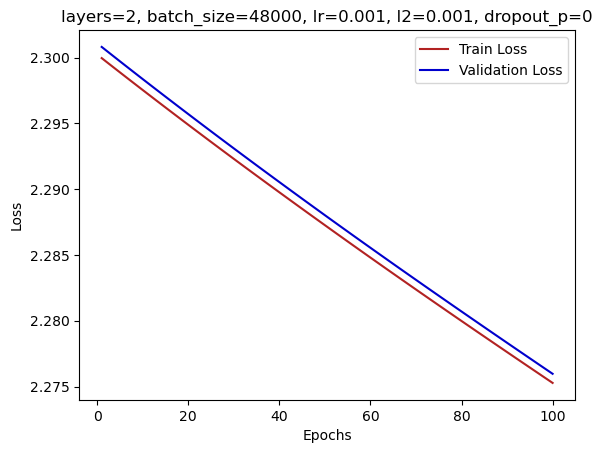

In [78]:
layers = 2
batch_size = len(train_subset)
lr = 0.001 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30728, Train Acc: 11.73% |            Validation Loss: 2.30458, Validation Acc: 12.17%
Epoch: 10 | Train Loss: 2.30685, Train Acc: 11.82% |            Validation Loss: 2.30353, Validation Acc: 12.26%
Epoch: 20 | Train Loss: 2.30554, Train Acc: 11.92% |            Validation Loss: 2.30247, Validation Acc: 12.43%
Epoch: 30 | Train Loss: 2.30468, Train Acc: 12.03% |            Validation Loss: 2.30142, Validation Acc: 12.53%
Epoch: 40 | Train Loss: 2.30336, Train Acc: 12.15% |            Validation Loss: 2.30036, Validation Acc: 12.66%
Epoch: 50 | Train Loss: 2.30282, Train Acc: 12.29% |            Validation Loss: 2.29931, Validation Acc: 12.77%
Epoch: 60 | Train Loss: 2.30155, Train Acc: 12.42% |            Validation Loss: 2.29826, Validation Acc: 12.92%
Epoch: 70 | Train Loss: 2.30037, Train Acc: 12.56% |            Validation Loss: 2.29720, Validation Acc: 12.95%
Epoch: 80 | Train Loss: 2.29925, Train Acc: 12.71% |            Validation Loss: 2.29614, Validat

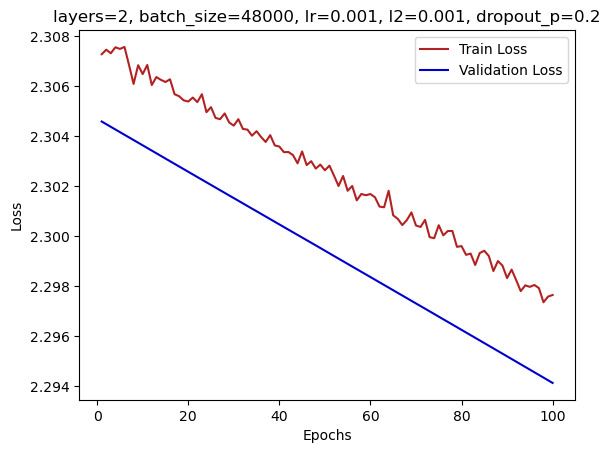

In [79]:
layers = 2
batch_size = len(train_subset)
lr = 0.001 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.31442, Train Acc: 5.69% |            Validation Loss: 2.31480, Validation Acc: 5.75%
Epoch: 10 | Train Loss: 2.31166, Train Acc: 5.98% |            Validation Loss: 2.31205, Validation Acc: 5.99%
Epoch: 20 | Train Loss: 2.30897, Train Acc: 6.42% |            Validation Loss: 2.30937, Validation Acc: 6.34%
Epoch: 30 | Train Loss: 2.30636, Train Acc: 6.85% |            Validation Loss: 2.30677, Validation Acc: 6.79%
Epoch: 40 | Train Loss: 2.30382, Train Acc: 7.42% |            Validation Loss: 2.30423, Validation Acc: 7.34%
Epoch: 50 | Train Loss: 2.30133, Train Acc: 8.17% |            Validation Loss: 2.30174, Validation Acc: 7.98%
Epoch: 60 | Train Loss: 2.29889, Train Acc: 9.16% |            Validation Loss: 2.29930, Validation Acc: 8.80%
Epoch: 70 | Train Loss: 2.29649, Train Acc: 10.26% |            Validation Loss: 2.29690, Validation Acc: 9.92%
Epoch: 80 | Train Loss: 2.29412, Train Acc: 11.44% |            Validation Loss: 2.29454, Validation Acc: 11.25%

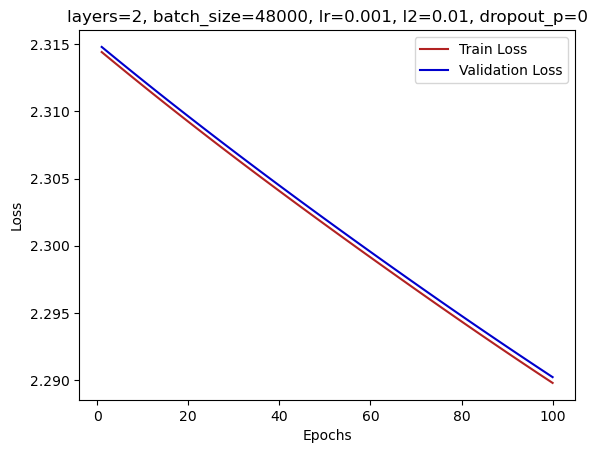

In [80]:
layers = 2
batch_size = len(train_subset)
lr = 0.001 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.31076, Train Acc: 10.55% |            Validation Loss: 2.30822, Validation Acc: 10.72%
Epoch: 10 | Train Loss: 2.30914, Train Acc: 10.57% |            Validation Loss: 2.30692, Validation Acc: 10.72%
Epoch: 20 | Train Loss: 2.30785, Train Acc: 10.59% |            Validation Loss: 2.30566, Validation Acc: 10.72%
Epoch: 30 | Train Loss: 2.30631, Train Acc: 10.61% |            Validation Loss: 2.30441, Validation Acc: 10.73%
Epoch: 40 | Train Loss: 2.30588, Train Acc: 10.65% |            Validation Loss: 2.30318, Validation Acc: 10.75%
Epoch: 50 | Train Loss: 2.30445, Train Acc: 10.67% |            Validation Loss: 2.30196, Validation Acc: 10.75%
Epoch: 60 | Train Loss: 2.30303, Train Acc: 10.70% |            Validation Loss: 2.30076, Validation Acc: 10.78%
Epoch: 70 | Train Loss: 2.30184, Train Acc: 10.73% |            Validation Loss: 2.29956, Validation Acc: 10.80%
Epoch: 80 | Train Loss: 2.30115, Train Acc: 10.76% |            Validation Loss: 2.29837, Validat

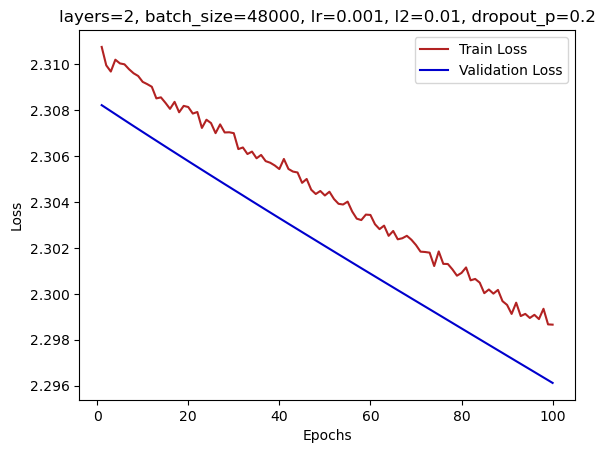

In [81]:
layers = 2
batch_size = len(train_subset)
lr = 0.001 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30691, Train Acc: 12.80% |            Validation Loss: 2.30537, Validation Acc: 13.08%
Epoch: 10 | Train Loss: 2.28768, Train Acc: 15.48% |            Validation Loss: 2.28622, Validation Acc: 15.62%
Epoch: 20 | Train Loss: 2.26917, Train Acc: 19.21% |            Validation Loss: 2.26771, Validation Acc: 19.13%
Epoch: 30 | Train Loss: 2.25014, Train Acc: 23.78% |            Validation Loss: 2.24873, Validation Acc: 23.67%
Epoch: 40 | Train Loss: 2.23069, Train Acc: 27.43% |            Validation Loss: 2.22932, Validation Acc: 27.37%
Epoch: 50 | Train Loss: 2.20992, Train Acc: 30.10% |            Validation Loss: 2.20838, Validation Acc: 30.33%
Epoch: 60 | Train Loss: 2.18549, Train Acc: 32.38% |            Validation Loss: 2.18390, Validation Acc: 32.21%
Epoch: 70 | Train Loss: 2.15994, Train Acc: 35.19% |            Validation Loss: 2.15824, Validation Acc: 34.61%
Epoch: 80 | Train Loss: 2.13296, Train Acc: 38.71% |            Validation Loss: 2.13110, Validat

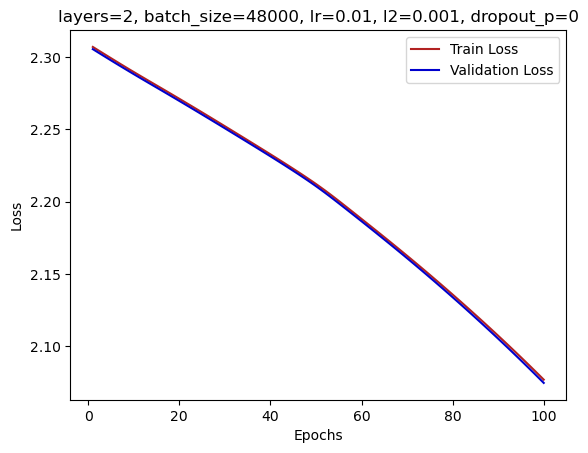

In [82]:
layers = 2
batch_size = len(train_subset)
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.31597, Train Acc: 9.74% |            Validation Loss: 2.31120, Validation Acc: 9.91%
Epoch: 10 | Train Loss: 2.29901, Train Acc: 11.96% |            Validation Loss: 2.29372, Validation Acc: 12.25%
Epoch: 20 | Train Loss: 2.28454, Train Acc: 16.33% |            Validation Loss: 2.27835, Validation Acc: 16.78%
Epoch: 30 | Train Loss: 2.27025, Train Acc: 18.57% |            Validation Loss: 2.26343, Validation Acc: 19.14%
Epoch: 40 | Train Loss: 2.25540, Train Acc: 20.78% |            Validation Loss: 2.24822, Validation Acc: 21.21%
Epoch: 50 | Train Loss: 2.24088, Train Acc: 22.83% |            Validation Loss: 2.23218, Validation Acc: 23.22%
Epoch: 60 | Train Loss: 2.22551, Train Acc: 25.79% |            Validation Loss: 2.21497, Validation Acc: 26.33%
Epoch: 70 | Train Loss: 2.20793, Train Acc: 29.53% |            Validation Loss: 2.19609, Validation Acc: 30.15%
Epoch: 80 | Train Loss: 2.18837, Train Acc: 33.88% |            Validation Loss: 2.17524, Validatio

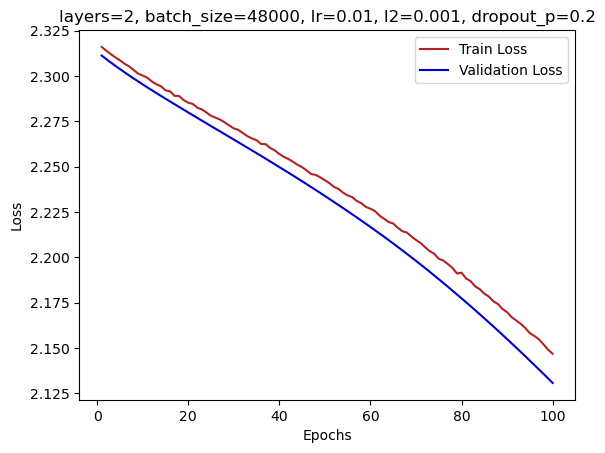

In [83]:
layers = 2
batch_size = len(train_subset)
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.29596, Train Acc: 14.20% |            Validation Loss: 2.29472, Validation Acc: 14.67%
Epoch: 10 | Train Loss: 2.28370, Train Acc: 20.79% |            Validation Loss: 2.28244, Validation Acc: 21.19%
Epoch: 20 | Train Loss: 2.27234, Train Acc: 25.29% |            Validation Loss: 2.27100, Validation Acc: 25.62%
Epoch: 30 | Train Loss: 2.26084, Train Acc: 28.29% |            Validation Loss: 2.25933, Validation Acc: 28.44%
Epoch: 40 | Train Loss: 2.24866, Train Acc: 30.73% |            Validation Loss: 2.24700, Validation Acc: 30.74%
Epoch: 50 | Train Loss: 2.23548, Train Acc: 32.87% |            Validation Loss: 2.23366, Validation Acc: 32.88%
Epoch: 60 | Train Loss: 2.22101, Train Acc: 34.84% |            Validation Loss: 2.21906, Validation Acc: 34.77%
Epoch: 70 | Train Loss: 2.20510, Train Acc: 36.83% |            Validation Loss: 2.20298, Validation Acc: 36.38%
Epoch: 80 | Train Loss: 2.18747, Train Acc: 38.96% |            Validation Loss: 2.18511, Validat

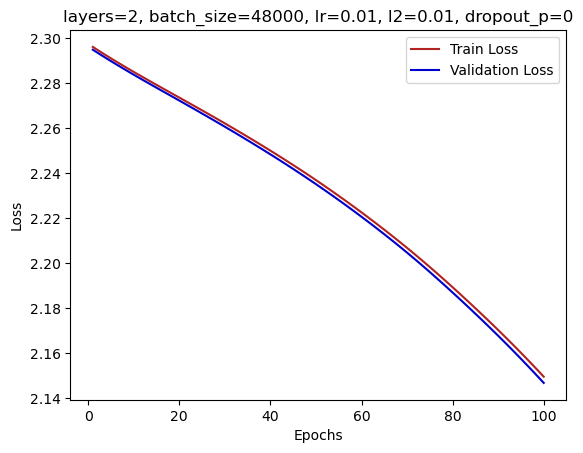

In [84]:
layers = 2
batch_size = len(train_subset)
lr = 0.01 
l2 = 0.01
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 2.30358, Train Acc: 11.91% |            Validation Loss: 2.29738, Validation Acc: 11.94%
Epoch: 10 | Train Loss: 2.27820, Train Acc: 18.72% |            Validation Loss: 2.27147, Validation Acc: 18.86%
Epoch: 20 | Train Loss: 2.25715, Train Acc: 27.71% |            Validation Loss: 2.24898, Validation Acc: 27.80%
Epoch: 30 | Train Loss: 2.23688, Train Acc: 31.92% |            Validation Loss: 2.22769, Validation Acc: 31.47%
Epoch: 40 | Train Loss: 2.21589, Train Acc: 35.80% |            Validation Loss: 2.20567, Validation Acc: 35.42%
Epoch: 50 | Train Loss: 2.19339, Train Acc: 39.41% |            Validation Loss: 2.18176, Validation Acc: 39.12%
Epoch: 60 | Train Loss: 2.16979, Train Acc: 42.82% |            Validation Loss: 2.15563, Validation Acc: 42.18%
Epoch: 70 | Train Loss: 2.14192, Train Acc: 45.52% |            Validation Loss: 2.12597, Validation Acc: 44.91%
Epoch: 80 | Train Loss: 2.11266, Train Acc: 47.62% |            Validation Loss: 2.09358, Validat

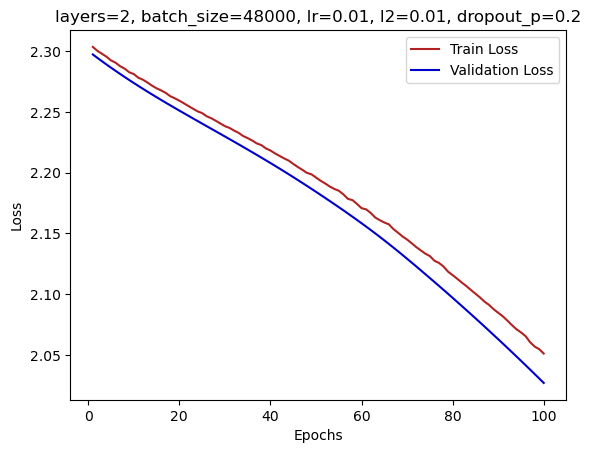

In [85]:
layers = 2
batch_size = len(train_subset)
lr = 0.01 
l2 = 0.01
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

We see that with Batch Gradient descent the train time is longer, it takes more epochs to converge even with just 2 layers.

The best results were in mini batch with batch size 30, learning rate 0.01, l2 regularization 0.001. <br>
Both 2 and 3 layers showed good results, but with dropout 0.2 the difference between train and validation loss was smaller. <br>
Let's try to fine tune, we will keep batch size 30 and learning rate 0.01, but try l2 with 0, 0.001, and dropout 0, 0.1, 0.2.<br>


Epoch: 0 | Train Loss: 0.75611, Train Acc: 89.12% |            Validation Loss: 0.37207, Validation Acc: 88.75%
Epoch: 10 | Train Loss: 0.10208, Train Acc: 97.44% |            Validation Loss: 0.12252, Validation Acc: 96.33%
Epoch: 20 | Train Loss: 0.05104, Train Acc: 98.77% |            Validation Loss: 0.09737, Validation Acc: 96.84%
Epoch: 30 | Train Loss: 0.02699, Train Acc: 99.45% |            Validation Loss: 0.09004, Validation Acc: 97.30%
Early stopping at epoch 31, with 0.08854 validation loss


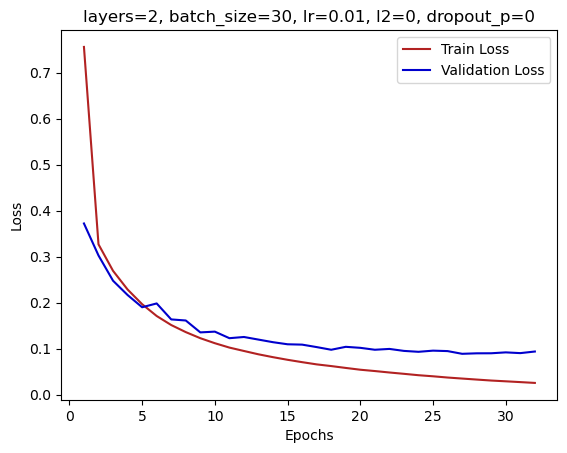

In [86]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.83879, Train Acc: 89.31% |            Validation Loss: 0.37574, Validation Acc: 89.09%
Epoch: 10 | Train Loss: 0.12734, Train Acc: 97.34% |            Validation Loss: 0.11909, Validation Acc: 96.35%
Epoch: 20 | Train Loss: 0.07509, Train Acc: 98.67% |            Validation Loss: 0.08911, Validation Acc: 97.27%
Epoch: 30 | Train Loss: 0.04998, Train Acc: 99.29% |            Validation Loss: 0.07694, Validation Acc: 97.61%
Epoch: 40 | Train Loss: 0.03718, Train Acc: 99.46% |            Validation Loss: 0.07855, Validation Acc: 97.67%
Early stopping at epoch 43, with 0.07067 validation loss


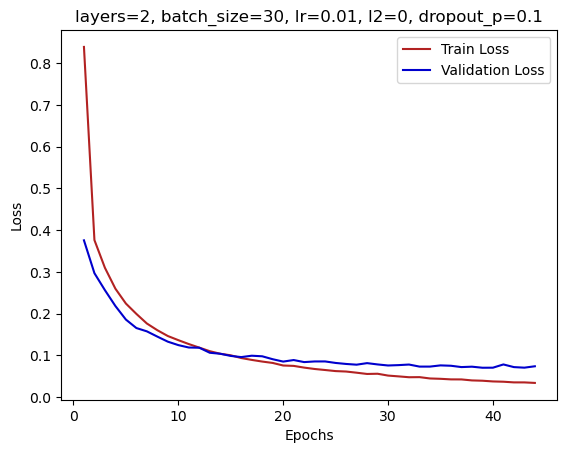

In [87]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0.1
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.94125, Train Acc: 88.86% |            Validation Loss: 0.40287, Validation Acc: 88.57%
Epoch: 10 | Train Loss: 0.14706, Train Acc: 97.29% |            Validation Loss: 0.11780, Validation Acc: 96.40%
Epoch: 20 | Train Loss: 0.09697, Train Acc: 98.47% |            Validation Loss: 0.09150, Validation Acc: 97.17%
Epoch: 30 | Train Loss: 0.07178, Train Acc: 99.03% |            Validation Loss: 0.08111, Validation Acc: 97.58%
Early stopping at epoch 37, with 0.07653 validation loss


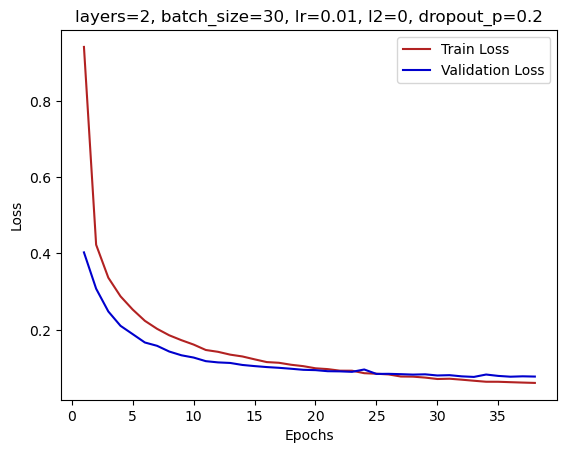

In [88]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.79033, Train Acc: 89.01% |            Validation Loss: 0.37748, Validation Acc: 89.08%
Epoch: 10 | Train Loss: 0.11078, Train Acc: 97.25% |            Validation Loss: 0.12679, Validation Acc: 96.23%
Epoch: 20 | Train Loss: 0.05999, Train Acc: 98.64% |            Validation Loss: 0.09250, Validation Acc: 97.16%
Epoch: 30 | Train Loss: 0.04132, Train Acc: 99.18% |            Validation Loss: 0.08209, Validation Acc: 97.38%
Epoch: 40 | Train Loss: 0.03099, Train Acc: 99.34% |            Validation Loss: 0.08294, Validation Acc: 97.47%


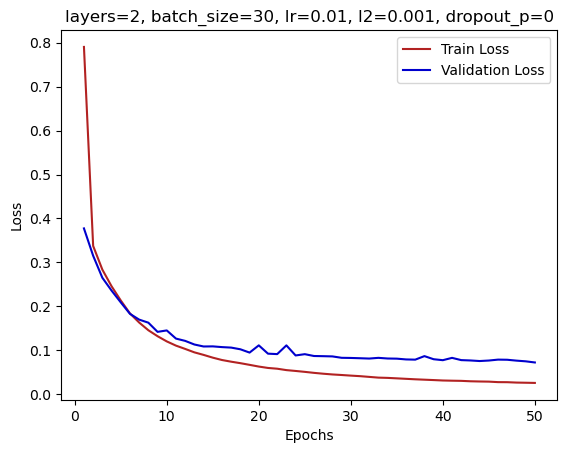

In [89]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 0.85598, Train Acc: 89.30% |            Validation Loss: 0.37597, Validation Acc: 89.04%
Epoch: 10 | Train Loss: 0.13208, Train Acc: 97.19% |            Validation Loss: 0.12249, Validation Acc: 96.32%
Epoch: 20 | Train Loss: 0.08260, Train Acc: 98.47% |            Validation Loss: 0.09105, Validation Acc: 97.24%
Epoch: 30 | Train Loss: 0.06423, Train Acc: 98.95% |            Validation Loss: 0.07778, Validation Acc: 97.67%
Epoch: 40 | Train Loss: 0.05253, Train Acc: 99.26% |            Validation Loss: 0.07312, Validation Acc: 97.67%


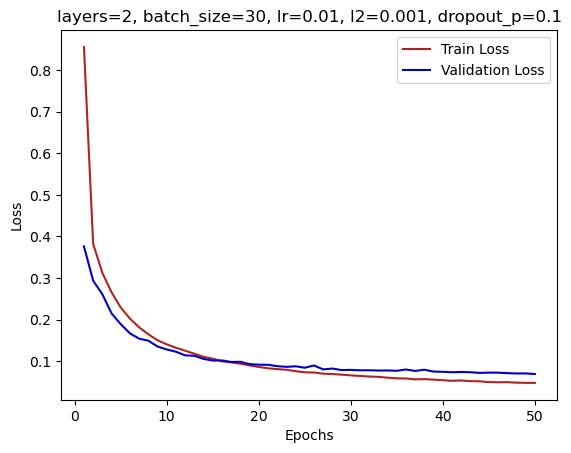

In [90]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.1
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

In [93]:
valid_losses[-1]

tensor(0.0689)

Epoch: 0 | Train Loss: 0.94289, Train Acc: 88.25% |            Validation Loss: 0.40946, Validation Acc: 87.94%
Epoch: 10 | Train Loss: 0.15856, Train Acc: 96.94% |            Validation Loss: 0.12724, Validation Acc: 96.09%
Epoch: 20 | Train Loss: 0.10367, Train Acc: 98.24% |            Validation Loss: 0.09518, Validation Acc: 97.08%
Epoch: 30 | Train Loss: 0.08433, Train Acc: 98.85% |            Validation Loss: 0.08109, Validation Acc: 97.52%
Epoch: 40 | Train Loss: 0.07172, Train Acc: 99.05% |            Validation Loss: 0.07798, Validation Acc: 97.61%


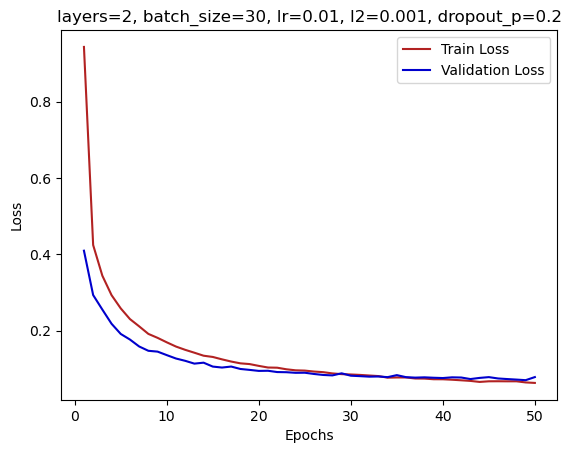

In [94]:
layers = 2
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

In [97]:
valid_losses[-5:-1]

[tensor(0.0750), tensor(0.0735), tensor(0.0721), tensor(0.0705)]

Epoch: 0 | Train Loss: 1.08028, Train Acc: 86.75% |            Validation Loss: 0.43906, Validation Acc: 86.48%
Epoch: 10 | Train Loss: 0.08969, Train Acc: 97.71% |            Validation Loss: 0.11434, Validation Acc: 96.71%
Epoch: 20 | Train Loss: 0.03685, Train Acc: 99.29% |            Validation Loss: 0.08598, Validation Acc: 97.50%
Early stopping at epoch 26, with 0.08434 validation loss


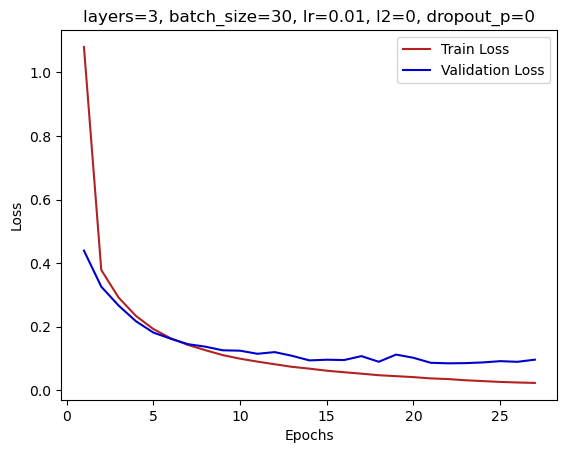

In [98]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.19140, Train Acc: 86.98% |            Validation Loss: 0.44905, Validation Acc: 86.88%
Epoch: 10 | Train Loss: 0.12191, Train Acc: 97.56% |            Validation Loss: 0.11270, Validation Acc: 96.68%
Epoch: 20 | Train Loss: 0.06866, Train Acc: 98.90% |            Validation Loss: 0.08754, Validation Acc: 97.35%
Epoch: 30 | Train Loss: 0.04628, Train Acc: 99.44% |            Validation Loss: 0.07860, Validation Acc: 97.58%
Early stopping at epoch 35, with 0.07860 validation loss


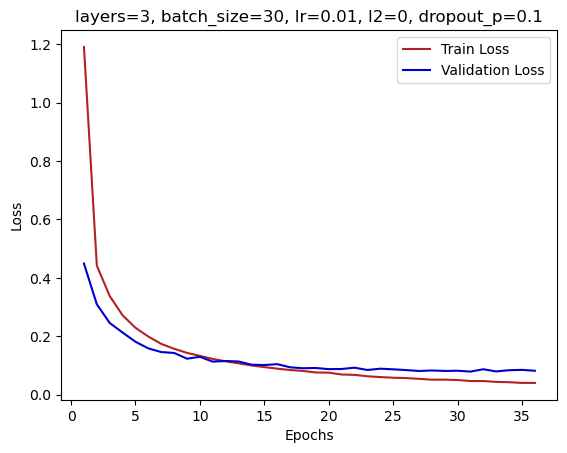

In [99]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0.1
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.33287, Train Acc: 85.17% |            Validation Loss: 0.50194, Validation Acc: 85.19%
Epoch: 10 | Train Loss: 0.15443, Train Acc: 97.25% |            Validation Loss: 0.12202, Validation Acc: 96.22%
Epoch: 20 | Train Loss: 0.09642, Train Acc: 98.56% |            Validation Loss: 0.09389, Validation Acc: 97.29%
Early stopping at epoch 29, with 0.08566 validation loss


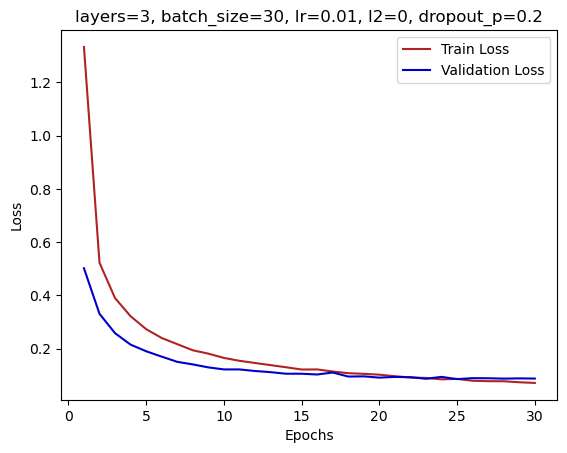

In [100]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.11514, Train Acc: 87.09% |            Validation Loss: 0.42403, Validation Acc: 86.61%
Epoch: 10 | Train Loss: 0.09852, Train Acc: 97.58% |            Validation Loss: 0.11817, Validation Acc: 96.42%
Epoch: 20 | Train Loss: 0.05040, Train Acc: 98.91% |            Validation Loss: 0.09138, Validation Acc: 97.23%
Early stopping at epoch 26, with 0.08550 validation loss


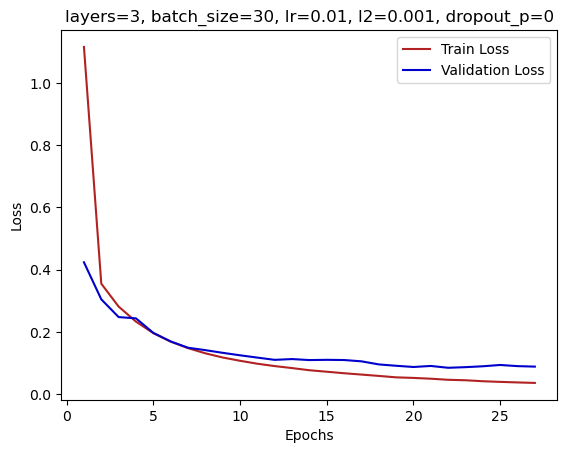

In [101]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.19404, Train Acc: 86.09% |            Validation Loss: 0.47352, Validation Acc: 86.08%
Epoch: 10 | Train Loss: 0.12955, Train Acc: 97.48% |            Validation Loss: 0.11559, Validation Acc: 96.47%
Epoch: 20 | Train Loss: 0.07980, Train Acc: 98.75% |            Validation Loss: 0.08841, Validation Acc: 97.28%
Epoch: 30 | Train Loss: 0.05757, Train Acc: 98.71% |            Validation Loss: 0.09113, Validation Acc: 97.21%
Epoch: 40 | Train Loss: 0.04822, Train Acc: 99.43% |            Validation Loss: 0.07662, Validation Acc: 97.72%
Early stopping at epoch 41, with 0.07612 validation loss


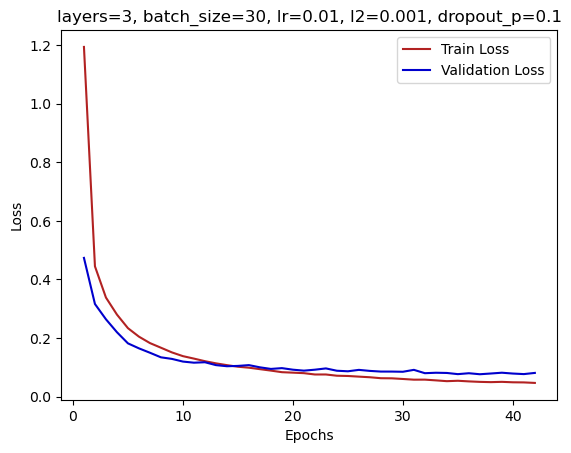

In [102]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.1
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

Epoch: 0 | Train Loss: 1.27588, Train Acc: 87.05% |            Validation Loss: 0.46392, Validation Acc: 87.12%
Epoch: 10 | Train Loss: 0.15605, Train Acc: 97.32% |            Validation Loss: 0.11551, Validation Acc: 96.53%
Epoch: 20 | Train Loss: 0.10654, Train Acc: 98.43% |            Validation Loss: 0.09162, Validation Acc: 97.21%
Epoch: 30 | Train Loss: 0.08153, Train Acc: 98.84% |            Validation Loss: 0.08442, Validation Acc: 97.52%
Early stopping at epoch 37, with 0.07837 validation loss


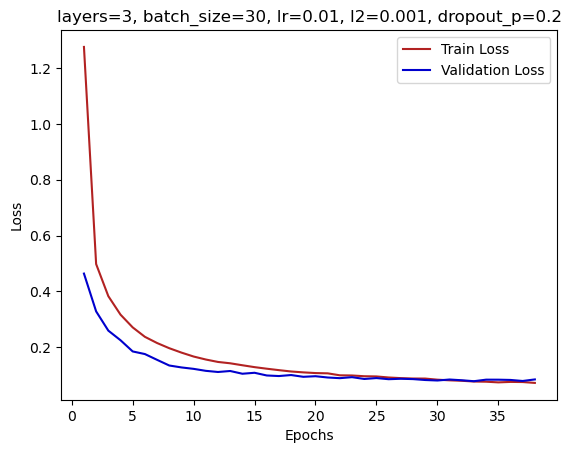

In [103]:
layers = 3
batch_size = 30
lr = 0.01 
l2 = 0.001
dropout_p = 0.2
parameters_string = f"layers={layers}, batch_size={batch_size}, lr={lr}, l2={l2}, dropout_p={dropout_p}"
train_losses, valid_losses = ModelTraining(layers, batch_size, lr, l2, dropout_p)
loss_vis(train_losses, valid_losses, "Train Loss", "Validation Loss", parameters_string)

### Choosing and Training the selected model

The best model: layers = 2, batch_size = 30, lr = 0.01, l2 = 0.001, dropout_p = 0.1 for 50 epochs.<br>
It achieved 0.0689 loss in the 50th epoch, without overfitting. 

In [136]:
model = BaseModel2(0.1)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=30, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

for epoch in range(50):

    model.train()
        
    for batch_idx, (data, target) in enumerate(trainloader):

        output_train = model(data)
        loss_train = loss_fn(output_train, target)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

Testing:

In [137]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset))
model.eval()
with torch.inference_mode():
            
    for data_test, target_test in testloader:
        output_test = model(data_test)
        pred_test = torch.softmax(output_test, dim=1).argmax(dim=1)
        loss_test = loss_fn(output_test, target_test)
        acc_test = accuracy_fn(target_test, pred_test)
            
print(f"Validation Loss: {loss_test:.5f}, Validation Acc: {acc_test:.2f}%")

Validation Loss: 0.06278, Validation Acc: 98.06%


### Visualizations

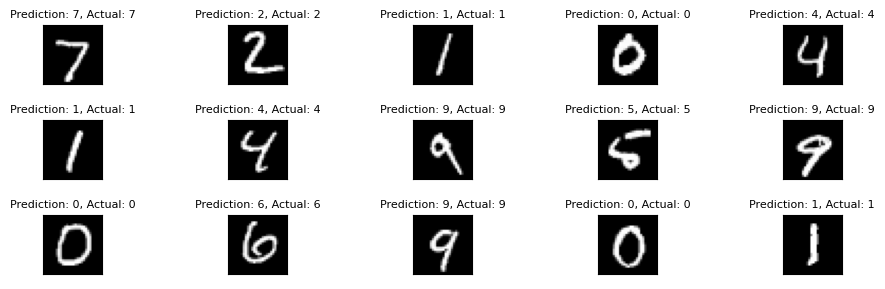

In [179]:
fig = plt.figure(figsize=(10,3))
for idx in np.arange(15):
    ax = fig.add_subplot(3, int(15/3), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(testset[idx][0]), cmap='gray')
    ax.set_title(f"Prediction: {pred_test[idx]}, Actual: {target_test[idx]}", fontsize = 8)
fig.tight_layout()

Examples where the model was wrong:

In [180]:
wrong_images = []
wrong_targets = []
wrong_pred = []
for idx in range(len(testset)):
    if target_test[idx] != pred_test[idx]:
        wrong_images.append(testset[idx])
        wrong_targets.append(target_test[idx])
        wrong_pred.append(pred_test[idx])

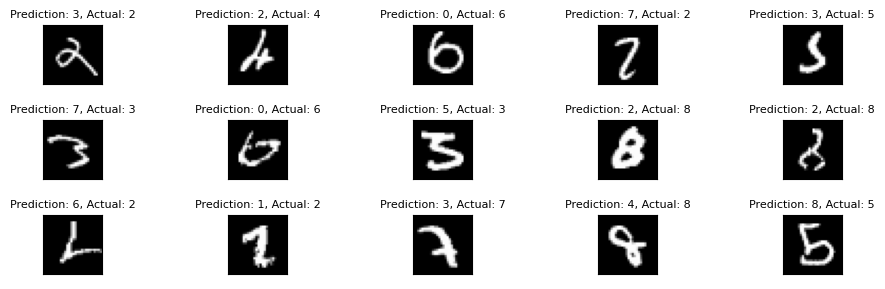

In [181]:
fig = plt.figure(figsize=(10,3))
for idx in np.arange(15):
    ax = fig.add_subplot(3, int(15/3), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(wrong_images[idx][0]), cmap='gray')
    ax.set_title(f"Prediction: {wrong_pred[idx]}, Actual: {wrong_targets[idx]}", fontsize = 8)
fig.tight_layout()

Confusion Matrix:

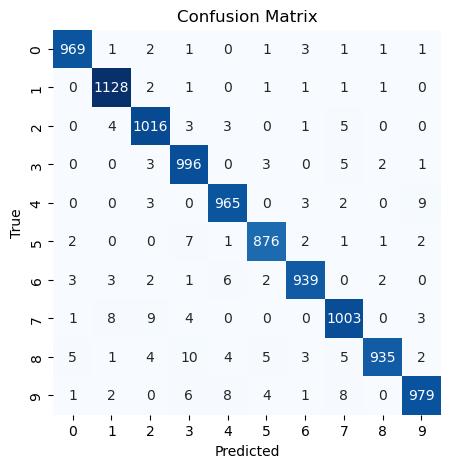

In [182]:
def plot_confusion_matrix(targets, predictions):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(target_test, pred_test)

Right/Wrong Predictions Distribution Bar Plot:

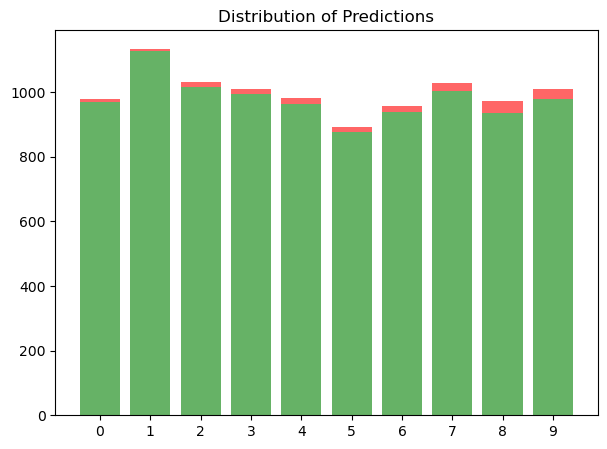

In [183]:
def plot_prediction_histogram(true_labels, predicted_labels):
    unique_labels = np.unique(true_labels)
    plt.figure(figsize=(7, 5))
    for i, label in enumerate(unique_labels):
        indices = np.where(true_labels == label)
        predicted_counts = np.bincount(predicted_labels[indices], minlength=10)
        correct_counts = predicted_counts[label]
        incorrect_counts = np.sum(predicted_counts) - correct_counts
        x_values = np.array([i])
        plt.bar(x_values, [correct_counts], color='g', label='Correct', alpha=0.6)
        plt.bar(x_values, [incorrect_counts], bottom=[correct_counts], color='r', label='Incorrect', alpha=0.6)
    plt.title('Distribution of Predictions')
    plt.xticks(np.arange(len(unique_labels)), unique_labels)
    plt.show()

plot_prediction_histogram(target_test, pred_test)